# Librerias

In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as math

from glob import glob
from collections import OrderedDict
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

# Funciones

In [2]:
#Lineal
def lineal(x,a,b):
  f= a*x+b
  return f

def gauss(X,X_mean,sigma,C):
    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

def ploteo_gauss(dt_x, dt_y, y_error, mu_ploteo, sigma_ploteo, C_ploteo, color_ploteo, label_ploteo, x_label, y_label, rtrn=False):

  pop_ploteo, cov_ploteo= curve_fit(f=gauss, xdata= dt_x, ydata= dt_y, p0=[mu_ploteo,sigma_ploteo,C_ploteo], sigma=y_error, maxfev=1000000)

  mu=round(pop_ploteo[0],0)
  sigma=pop_ploteo[1]
  C=pop_ploteo[2]

  fig,ax = plt.subplots()
  plt.errorbar(dt_x,dt_y, yerr=y_error, fmt=".:" , color=color_ploteo , label=label_ploteo)
  plt.plot(dt_x,gauss(dt_x, mu, sigma, C),color='gold')
  plt.vlines(mu, ymin=0, ymax= max(dt_y), color= "red" )
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

  print('El maximo es en el canal: ', round(mu,0), 'y el sigma es: ', sigma, 'La constante C es: ', C)
  print('Las incertezas son: ', np.sqrt(np.diag(cov_ploteo)))


  if rtrn==False:
    return

  elif rtrn==True:
    return mu, sigma, C, np.sqrt(np.diag(cov_ploteo))


def Doble_gauss(X, X_mean1, sigma1, C1, X_mean2, sigma2, C2):
    return C1*np.exp(-(X-X_mean1)**2/(2*sigma1**2)) + C2*np.exp(-(X-X_mean2)**2/(2*sigma2**2))

def ploteo_Doble_gauss(dt_x, dt_y, y_error, mu_ploteo1, sigma_ploteo1, C_ploteo1, mu_ploteo2, sigma_ploteo2, C_ploteo2, color_ploteo, label_ploteo, x_label, y_label, rtrn=False):

  pop_ploteo, cov_ploteo= curve_fit(f=Doble_gauss, xdata= dt_x, ydata= dt_y, sigma=y_error, p0=[mu_ploteo1, sigma_ploteo1, C_ploteo1, mu_ploteo2, sigma_ploteo2, C_ploteo2], maxfev=1000000)

  mu1=round(pop_ploteo[0],0)
  sigma1=pop_ploteo[1]
  C1=pop_ploteo[2]

  mu2=round(pop_ploteo[3],0)
  sigma2=pop_ploteo[4]
  C2=pop_ploteo[5]

  fig,ax = plt.subplots()
  plt.errorbar(dt_x,dt_y, yerr=y_error, fmt=".:" , color=color_ploteo , label=label_ploteo)
  plt.plot(dt_x,Doble_gauss(dt_x, mu1, sigma1, C1, mu2, sigma2, C2),color='gold')
  plt.vlines(mu1, ymin=0, ymax= max(dt_y), color= "red" )
  plt.vlines(mu2, ymin=0, ymax= max(dt_y), color= "red" )
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

  print('El maximo 1 esta en: ', round(mu1,0), 'y el sigma es: ', sigma1, 'La constante C es: ', C1)
  print('El maximo 2 esta en: ', round(mu2,0), 'y el sigma es: ', sigma2, 'La constante C es: ', C2)
  print('Las incertezas son: ', np.sqrt(np.diag(cov_ploteo)))

  return

In [3]:
def Suma_Riemann(dt_x, dt_y, lim_inf, lim_sup):
    
    rango=range(lim_inf,lim_sup)

    suma_inf=0

    for i in rango:

        Delta_x=dt_x[i+1]-dt_x[i]

        suma_inf+= dt_y[i]*Delta_x

    return suma_inf

# Datos

In [4]:
Rutas=glob('D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\*.Spe')

In [5]:
def sep_espesores(input_string):
    # Dividir la cadena en dos partes: número y texto
    match = re.match(r'(\d*\.?\d+)([a-zA-Z]+)', input_string)

    if match:
        number_part = float(match.group(1)) # Convertir la parte numérica a float
        text_part = match.group(2) # Parte de texto
        return number_part, text_part
    else:
        return None, None

Error en espesores: si existen n placas, el error es $\sigma=\sqrt (\sum_1^n (0.05)^2)$ [mm]

In [6]:
def err_espesor(n_placas, incerteza):

    return np.sqrt((incerteza**2)*n_placas)

El intervalo de incerteza en las cuentas por canal se debe a la naturaleza aleatoria de este proceso, de modo que tomamos $\sigma = \sqrt n$

In [7]:
Datos={}

Fondo=pd.read_csv('D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\FONDO-0placas-d-0-mm.Spe', names=['cuentas'], header=11, nrows=1024)

for ruta in Rutas:

  Lista=[]

  #Caracterizacion

  archivo_completo= os.path.basename(ruta)
  nombre_archivo= os.path.splitext(archivo_completo)[0]
  bloques_texto=nombre_archivo.split('-')
  cadena=bloques_texto[3]
  separador=cadena.replace('_','.')

  elemento=bloques_texto[0]
  placas=sep_espesores(bloques_texto[1])[0]
  espesor=float(separador)

  array= pd.read_csv(ruta, names=['cuentas'], header=11, nrows=1024)
  Colum_datos=array['cuentas']-Fondo['cuentas']
  
  Colum_Errores= np.sqrt(array['cuentas'])

  #Normalizacion
  
  row_index = 9
  Data= pd.read_csv(ruta, names=['cuentas'], skiprows=lambda x: x != row_index)
  tiempos=Data['cuentas']
  cadena=tiempos[0]
  string_tiempo= cadena.split()[0]
  tiempo_vivo=float(string_tiempo)

  dt_norm=Colum_datos/tiempo_vivo
  err_norm=Colum_Errores/tiempo_vivo


  Lista+=[elemento, espesor, placas, Colum_datos, dt_norm, err_norm]
  Datos[ruta]=Lista

In [8]:
canales=np.arange(0,1024,1)
Ba_I0=Datos['D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\Ba133-0placas-d-0-mm.Spe'][4]
Am_I0=Datos['D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\Am241-0placas-d-0-mm.Spe'][4]
Cs_I0=Datos['D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\Cs137-0placas-d-0-mm.Spe'][4]
Na_I0=Datos['D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\Na22-0placas-d-0-mm.Spe'][4]
Co_I0_p1=Datos['D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\Co60-0placas-d-0-mm-parcial1.Spe'][4]
Co_I0_p2=Datos['D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\Co60-0placas-d-0-mm-parcial2.Spe'][4]
Co_I0=Co_I0_p1+Co_I0_p1

Ba_I0_err=Datos['D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\Ba133-0placas-d-0-mm.Spe'][5]
Am_I0_err=Datos['D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\Am241-0placas-d-0-mm.Spe'][5]
Cs_I0_err=Datos['D:\Genaro\Experimentos Cuanticos II\TP1- Rayos Gamma\Datos\Cs137-0placas-d-0-mm.Spe'][5]
Na_I0_err=Datos['D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\Na22-0placas-d-0-mm.Spe'][5]
Co_I0_p1_err=Datos['D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\Co60-0placas-d-0-mm-parcial1.Spe'][5]
Co_I0_p2_err=Datos['D:\\Genaro\\Experimentos Cuanticos II\\TP1- Rayos Gamma\\Datos\\Co60-0placas-d-0-mm-parcial2.Spe'][5]
Co_I0_err=np.sqrt(Co_I0_p1_err**2+Co_I0_p1_err**2)

# Calibracion

## Ajustes Gausseanos

### Sodio 22

Espectro Completo
Ajustes


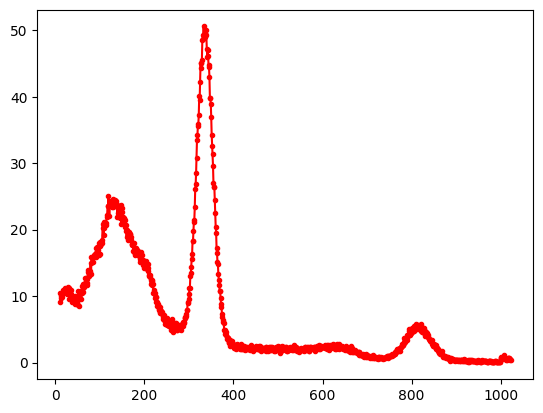

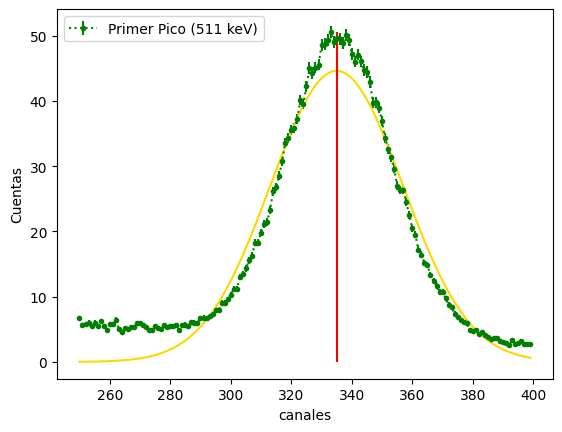

El maximo es en el canal:  335.0 y el sigma es:  21.89906263983182 La constante C es:  44.60188921882945
Las incertezas son:  [0.50502805 0.42903268 1.31805882]


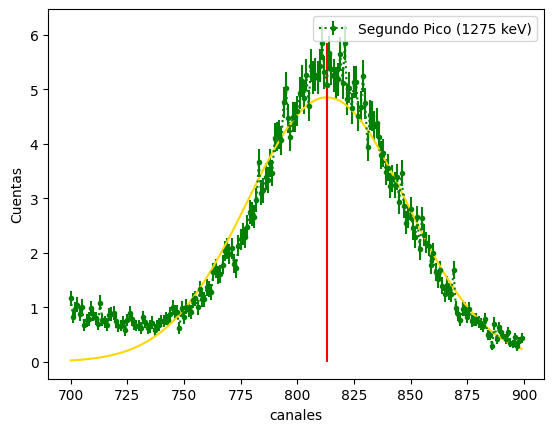

El maximo es en el canal:  813.0 y el sigma es:  35.04141465680397 La constante C es:  4.853566324626483
Las incertezas son:  [0.63787173 0.55740273 0.11141312]


In [9]:
print('Espectro Completo')
plt.plot(canales[10:], Na_I0[10:], marker='.', color='red')

print('Ajustes')
ploteo_gauss(canales[250:400], Na_I0[250:400], Na_I0_err[250:400], 300,2,1, "green","Primer Pico (511 keV)","canales", "Cuentas")
ploteo_gauss(canales[700:900], Na_I0[700:900], Na_I0_err[700:900], 700,2,1, "green","Segundo Pico (1275 keV)","canales", "Cuentas")

picos_Na=[335,814]
err_Na=[0.5,0.6]
E_Na=[511,1275]

### Cesio 147

Espectro Completo
Ajustes


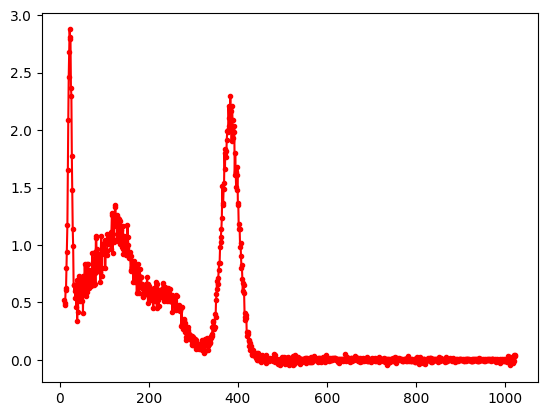

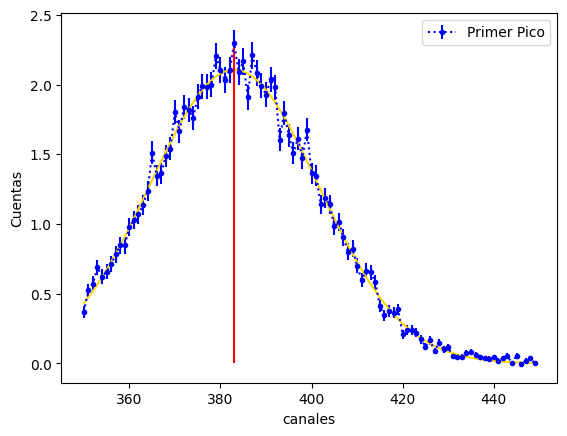

El maximo es en el canal:  383.0 y el sigma es:  18.529303125179094 La constante C es:  2.1058404206127093
Las incertezas son:  [0.1681143  0.14563226 0.02076172]


In [10]:
print('Espectro Completo')
plt.plot(canales[10:1024], Cs_I0[10:1024], marker='.', color='red')

print('Ajustes')
ploteo_gauss(canales[350:450], Cs_I0[350:450], Cs_I0_err[350:450], 375,5,1, "blue","Primer Pico","canales", "Cuentas")

picos_Cs=[383]
err_Cs=[0.2]
E_Cs=[662]

### Americio 241

Espectro Completo


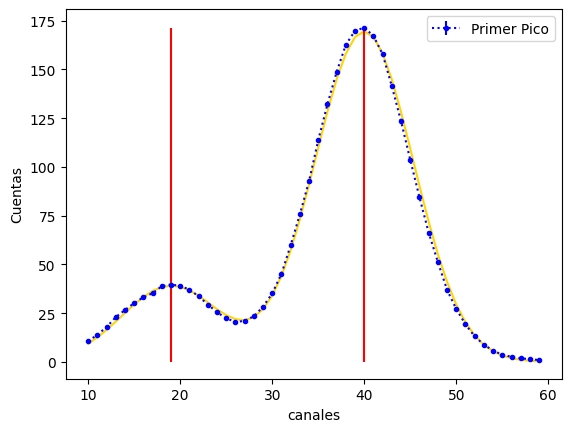

El maximo 1 esta en:  40.0 y el sigma es:  5.3413244453665465 La constante C es:  169.59113607550026
El maximo 2 esta en:  19.0 y el sigma es:  5.323817666460838 La constante C es:  39.053468950050615
Las incertezas son:  [0.02812969 0.02358245 0.98373866 0.07237667 0.08161597 0.52111507]


In [11]:
print('Espectro Completo')
plt.plot(canales[10:200], Am_I0[10:200], marker='.', color='red')

ploteo_Doble_gauss(canales[10:60], Am_I0[10:60], Am_I0_err[10:60], 22,5,1,40,2,1, "blue","Primer Pico","canales", "Cuentas")

picos_Am=[40]
err_Am=[0.1]
E_Am=[59]

### Bario 133

Espectro Completo
Ajustes


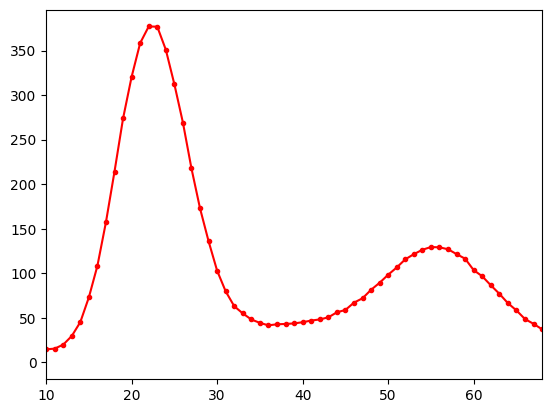

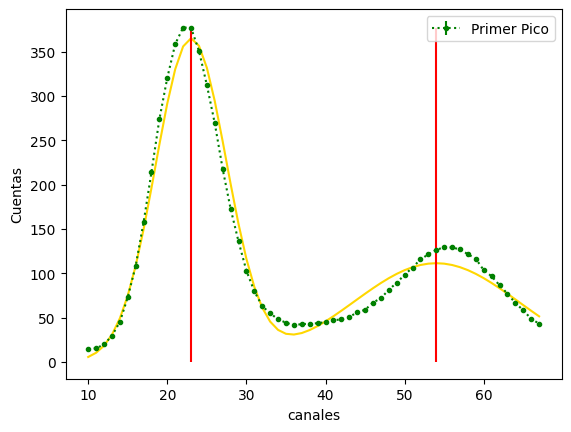

El maximo 1 esta en:  54.0 y el sigma es:  10.460491622926616 La constante C es:  111.3343450321629
El maximo 2 esta en:  23.0 y el sigma es:  4.495531630323721 La constante C es:  363.64936936987425
Las incertezas son:  [0.38282041 0.4560592  3.95828274 0.09888326 0.08068844 9.35062664]


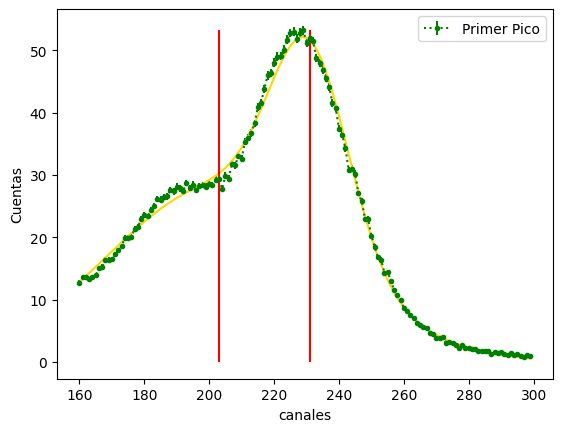

El maximo 1 esta en:  203.0 y el sigma es:  34.29687445077183 La constante C es:  28.160740820823708
El maximo 2 esta en:  231.0 y el sigma es:  12.006463177956071 La constante C es:  31.41882476232735
Las incertezas son:  [0.42427024 0.26498557 0.35504631 0.17348174 0.18882837 0.46306861]
picos


In [12]:
print('Espectro Completo')
#plt.semilogy(canales[10:243], Ba_I0[10:243], marker='.', color='red')
plt.plot(canales[10:], Ba_I0[10:], marker='.', color='red')
plt.xlim(10,68)


print('Ajustes')
ploteo_Doble_gauss(canales[10:68], Ba_I0[10:68], Ba_I0_err[10:68], 22,5,1,40,5,1, "green","Primer Pico","canales", "Cuentas")
ploteo_Doble_gauss(canales[160:300], Ba_I0[160:300], Ba_I0_err[160:300], 190,5,1,240,5,1, "green","Primer Pico","canales", "Cuentas")

print('picos')
picos_Ba=[23,54,231]
err_Ba=[0.4,0.1,0.4]
E_Ba=[31,81,356]

### Cobalto 60

Espectro Completo
Ajustes


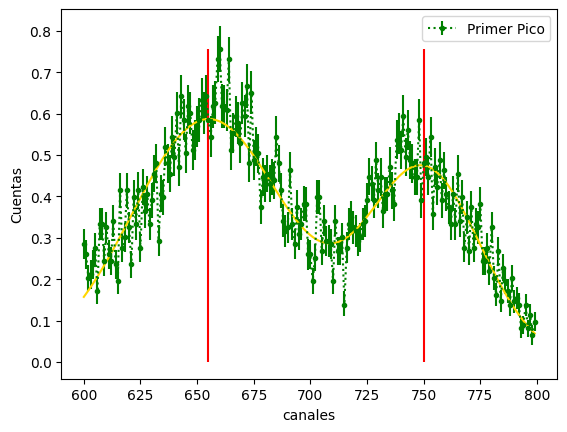

El maximo 1 esta en:  655.0 y el sigma es:  33.88145140852276 La constante C es:  0.5867615464353126
El maximo 2 esta en:  750.0 y el sigma es:  25.07169800115598 La constante C es:  0.4632560140354233
Las incertezas son:  [0.89935912 1.12034104 0.01277347 0.98547983 0.90468853 0.01249906]
picos


In [13]:
print('Espectro Completo')
#plt.semilogy(canales[:], Co_I0[:], marker='.', color='red')
#plt.plot(canales[:], Co_I0[:], marker='.', color='red')
#plt.xlim(600,800)

print('Ajustes')
ploteo_Doble_gauss(canales[600:800], Co_I0[600:800], Co_I0_err[600:800], 650,5,1,750,5,1, "green","Primer Pico","canales", "Cuentas")

print('picos')
picos_Co=[655,750]
err_Co=[1,1]
E_Co=[1173.2,1332.5]

## Energia vs Canales

In [14]:
Picos=[]
err_Picos=[]
Energias=[]

Picos+=picos_Ba
Picos+=picos_Am
Picos+=picos_Cs
Picos+=picos_Na
Picos+=picos_Co

err_Picos+=err_Ba
err_Picos+=err_Am
err_Picos+=err_Cs
err_Picos+=err_Na
err_Picos+=err_Co

Energias+=E_Ba
Energias+=E_Am
Energias+=E_Cs
Energias+=E_Na
Energias+=E_Co

Picos=np.array(Picos)
err_Picos=np.array(err_Picos)
Energias=np.array(Energias)

In [15]:
pop, cov= curve_fit(f=lineal, xdata= Picos, ydata= Energias, sigma= err_Picos, maxfev=1000000)

err=np.sqrt(np.diag(cov))

print(pop[0], pop[1])
print(err[0], err[1])

p= pop[0]
b= pop[1]

Eje_Energia= p*canales+b

fig,ax = plt.subplots()
plt.errorbar(Picos, Energias, xerr=err_Picos, fmt="." , color='red' , label='scatter')
plt.plot(Picos, lineal(Picos, pop[0], pop[1]), color='gold')
plt.xlabel('Canales')
plt.ylabel('Energias')
plt.legend()
plt.show()

1.6928322013866546 -9.027414437613627
0.04148601965331152 7.3529976932234815


# Corroboracion

## Cobalto 60

In [16]:
print('Espectro Completo')
#plt.semilogy(Eje_Energia[:], Co_I0[:], marker='.', color='red')
#plt.plot(Eje_Energia[:], Co_I0[:], marker='.', color='red')
#plt.xlim(600,800)


print('Ajustes')
ploteo_Doble_gauss(Eje_Energia[600:800], Co_I0[600:800], Co_I0_err[600:800], 1100,5,1,1300,5,1, "green","Primer Pico","Eje_Energia", "Cuentas")

print('picos')
picos_Co=[656,750]
E_Co=[1173.2,1332.5]

Espectro Completo
Ajustes


El maximo 1 esta en:  1100.0 y el sigma es:  57.35551499906257 La constante C es:  0.5867617709277023
El maximo 2 esta en:  1261.0 y el sigma es:  42.44227795696572 La constante C es:  0.46325589327879435
Las incertezas son:  [1.52246236 1.89655636 0.01277345 1.66823837 1.53146881 0.01249911]
picos


## Bario 133

Espectro Completo
Ajustes


El maximo 1 esta en:  83.0 y el sigma es:  17.708019333833168 La constante C es:  111.33373947860467
El maximo 2 esta en:  30.0 y el sigma es:  7.610157350000766 La constante C es:  363.65007178172334
Las incertezas son:  [0.64807888 0.77207712 3.9582309  0.16739296 0.13659203 9.35068768]


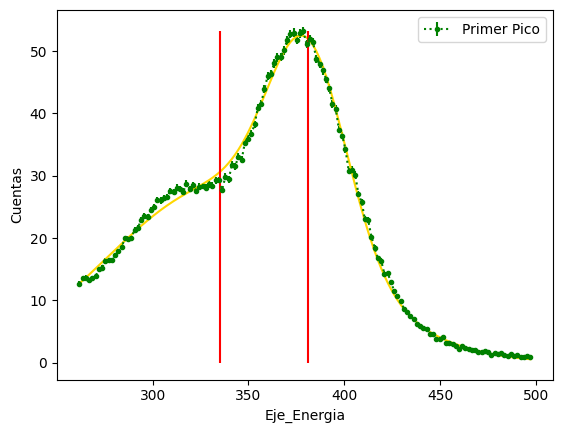

El maximo 1 esta en:  335.0 y el sigma es:  58.058762061947604 La constante C es:  28.16083509223155
El maximo 2 esta en:  381.0 y el sigma es:  20.324827324892457 La constante C es:  31.41878123835698
Las incertezas son:  [0.71825273 0.44859392 0.35505368 0.29367869 0.31965854 0.46307092]
picos


In [17]:
print('Espectro Completo')
#plt.semilogy(Eje_Energia[10:243], Ba_I0[10:243], marker='.', color='red')
plt.plot(Eje_Energia[10:], Ba_I0[10:], marker='.', color='red')
plt.xlim(10,68)


print('Ajustes')
ploteo_Doble_gauss(Eje_Energia[10:68], Ba_I0[10:68], Ba_I0_err[10:68],31,5,1,40,5,1, "green","Primer Pico","Eje_Energia", "Cuentas")
ploteo_Doble_gauss(Eje_Energia[160:300], Ba_I0[160:300], Ba_I0_err[160:300], 300,5,1,400,5,1, "green","Primer Pico","Eje_Energia", "Cuentas")

print('picos')
picos_Ba=[23,55,230]
E_Ba=[31,81,356]

## Sodio 22

Espectro Completo
Ajustes


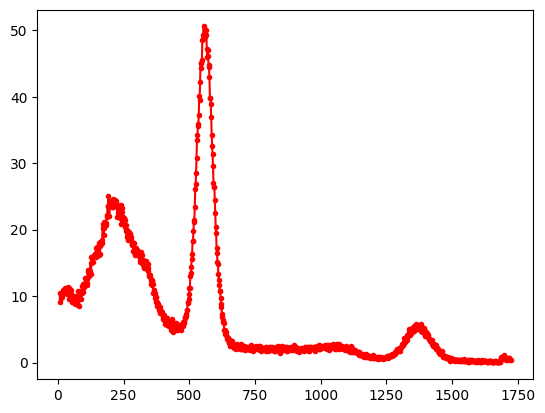

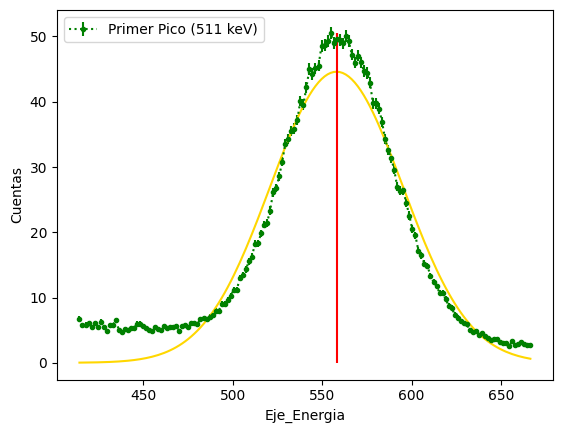

El maximo es en el canal:  558.0 y el sigma es:  37.071643715982425 La constante C es:  44.601649904951515
Las incertezas son:  [0.85493605 0.72628965 1.3180441 ]


El maximo es en el canal:  1367.0 y el sigma es:  59.31912111797756 La constante C es:  4.853575054585663
Las incertezas son:  [1.07980519 0.94358344 0.11141357]


In [18]:
print('Espectro Completo')
plt.plot(Eje_Energia[10:], Na_I0[10:], marker='.', color='red')

print('Ajustes')
ploteo_gauss(Eje_Energia[250:400], Na_I0[250:400], Na_I0_err[250:400], 550,2,1, "green","Primer Pico (511 keV)","Eje_Energia", "Cuentas")
ploteo_gauss(Eje_Energia[700:900], Na_I0[700:900], Na_I0_err[700:900], 1400,2,1, "green","Segundo Pico (1275 keV)","Eje_Energia", "Cuentas")

picos_Na=[335, 814]
E_Na=[511,1275]

## Americio 241

El pico esta en:  59


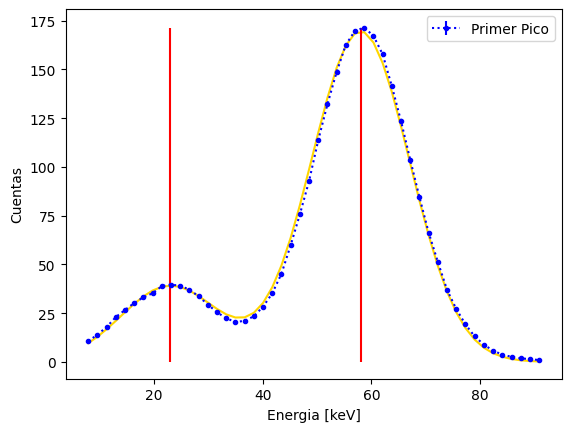

El maximo 1 esta en:  23.0 y el sigma es:  9.012329877749153 La constante C es:  39.05346963842767
El maximo 2 esta en:  58.0 y el sigma es:  9.041965623403119 La constante C es:  169.59114295777354
Las incertezas son:  [0.12252178 0.13816253 0.52111473 0.04761884 0.03992114 0.98373948]


In [19]:
print('El pico esta en: ', E_Am[0])
plt.plot(Eje_Energia[10:200], Am_I0[10:200], marker='.', color='red')

ploteo_Doble_gauss(Eje_Energia[10:60], Am_I0[10:60], Am_I0_err[10:60],22,5,1,E_Am[0],2,1, "blue","Primer Pico","Energia [keV]", "Cuentas")

picos_Am=[40]
E_Am=[59]

## Cesio 147

El pico esta en:  662


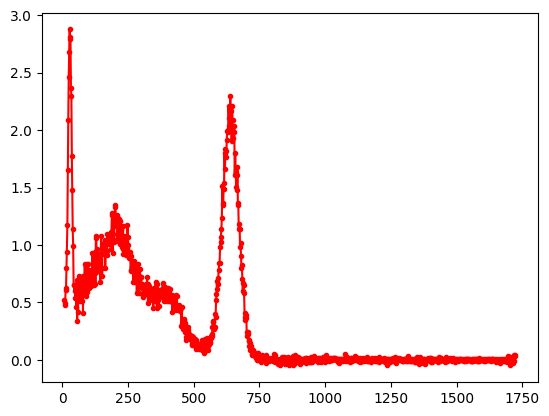

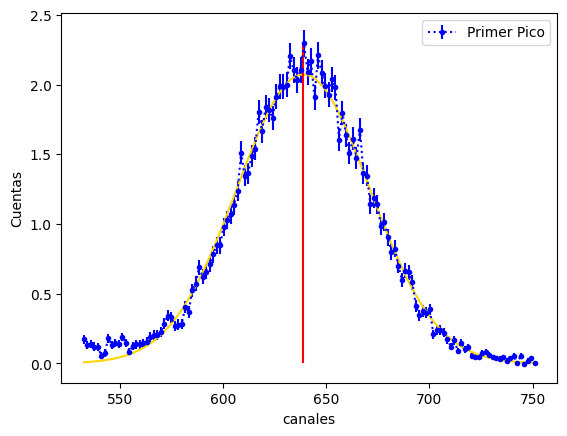

El maximo es en el canal:  639.0 y el sigma es:  32.110255860489744 La constante C es:  2.0727761653107644
Las incertezas son:  [0.37601551 0.30395507 0.02895483]


In [20]:
print('El pico esta en: ', E_Cs[0])

plt.plot(Eje_Energia[10:1024], Cs_I0[10:1024], marker='.', color='red')
ploteo_gauss(Eje_Energia[320:450], Cs_I0[320:450], Cs_I0_err[320:450], E_Cs[0],5,1, "blue","Primer Pico","canales", "Cuentas")

picos_Cs=[383]
E_Cs=[662]

# Graficos atenuaciones completos

In [21]:
Am_u={}
Ba_u={}
Cs_u={}
Co_u={}
Na_u={}

for i in Datos.values():

    espesor=i[1]
    espesor_err=err_espesor(i[2], 0.05)
    data_norm=i[4]
    data_err=i[5]

    if i[0]=='Am241':
        Am_u[espesor]=[np.array(data_norm), np.array(data_err), espesor_err]
    if i[0]=='Ba133':
        Ba_u[espesor]=[np.array(data_norm), np.array(data_err), espesor_err]
    if i[0]=='Cs137':
        Cs_u[espesor]=[np.array(data_norm), np.array(data_err), espesor_err]
    if i[0]=='Co60':
        Co_u[espesor]=[np.array(data_norm), np.array(data_err), espesor_err]
    if i[0]=='Na22':
        Na_u[espesor]=[np.array(data_norm), np.array(data_err), espesor_err]

Am = dict(sorted(Am_u.items()))
Ba = dict(sorted(Ba_u.items()))
Cs = dict(sorted(Cs_u.items()))
Co = dict(sorted(Co_u.items()))
Na = dict(sorted(Na_u.items()))

list_dicc=[Am, Ba, Cs, Co, Na]

In [22]:
Colores=['midnightblue','blue','blueviolet','darkviolet','purple','magenta','crimson','red']
titulos=['Atenuacion Americio', 'Atenuacion Bario', 'Atenuacion Cesio', 'Atenuacion Cobalto', 'Atenuacion Sodio']

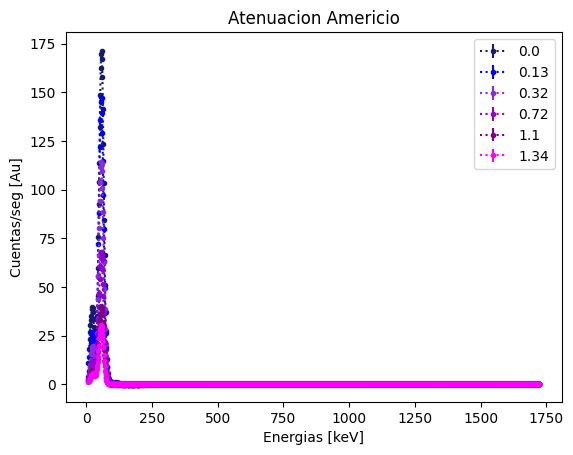

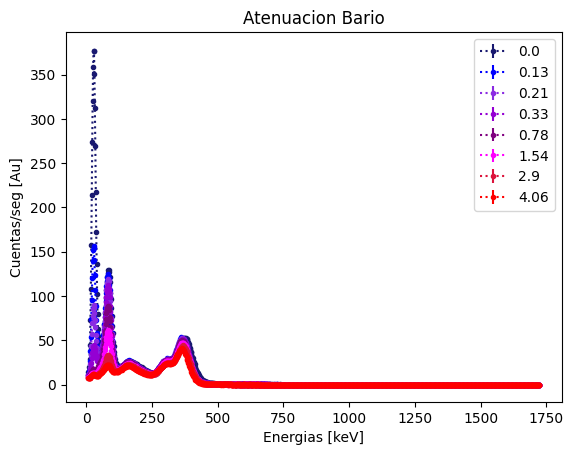

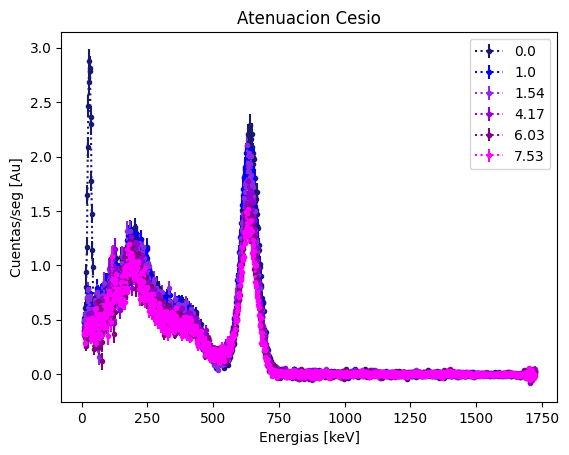

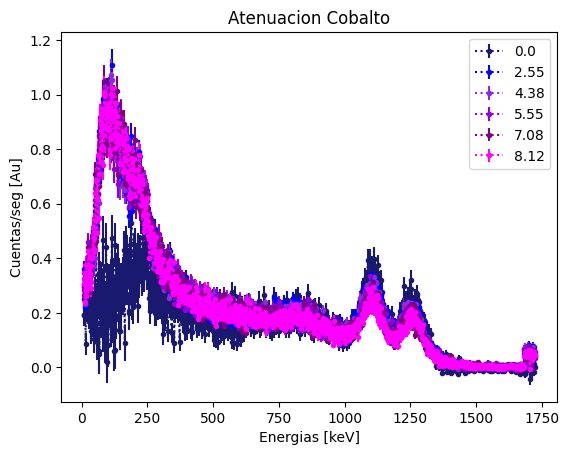

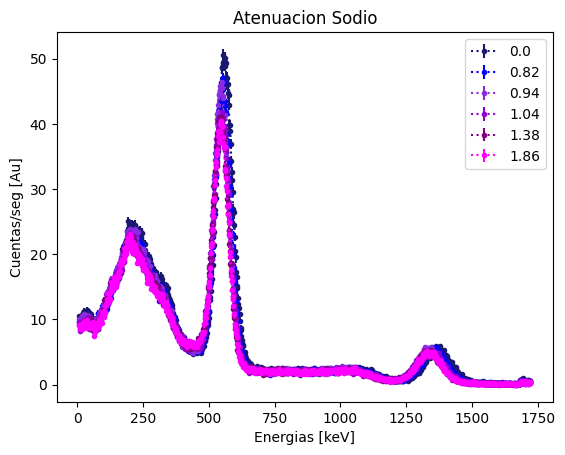

In [23]:
t=0

for dicc in list_dicc:

    c=0
    
    for esp in dicc.keys():

        plt.errorbar(Eje_Energia[10:], dicc[esp][0][10:], yerr=dicc[esp][1][10:], fmt='.:', color=Colores[c], label=str(esp))
        c=c+1
    
    plt.xlabel('Energias [keV]')
    plt.ylabel('Cuentas/seg [Au]')
    plt.title(titulos[t])
    plt.legend()
    plt.show()

    t=t+1


# Intensidades

## Integral Gausseana

In [24]:
def Gauss_int(sigma, Constante):
    return Constante*sigma*np.sqrt(2*np.pi)

def gauss(X,X_mean,sigma,C):
    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

def Doble_gauss(X, X_mean1, sigma1, C1, X_mean2, sigma2, C2):
    return C1*np.exp(-(X-X_mean1)**2/(2*sigma1**2)) + C2*np.exp(-(X-X_mean2)**2/(2*sigma2**2))

In [25]:
#Error en el calculo del area:

def err_gauss(sigma, C, err_sigma, err_C):

    return np.sqrt((2*np.pi)*(sigma*err_C)**2+(C*err_sigma)**2)

### Sodio

In [26]:
#Error Espesor
List_err_Esp_Na=[]

for i in Na.values():
    List_err_Esp_Na.append(i[2])

Esp_Na_err=np.array(List_err_Esp_Na)

Primer Pico

Espesor:  0.0 sigma=  37.07152547641084 +- 0.7262755897048737 Constante= 44.60178773506544
Espesor:  0.82 sigma=  37.38425656962195 +- 0.7557928722029233 Constante= 40.05909461089823
Espesor:  0.94 sigma=  37.353960281839804 +- 0.7276517679871675 Constante= 39.92620290555175
Espesor:  1.04 sigma=  39.2370792624947 +- 0.8299223354758953 Constante= 35.39170059606975
Espesor:  1.38 sigma=  39.216433408727866 +- 0.8367153520928324 Constante= 34.97997803302111
Espesor:  1.86 sigma=  39.61540831511847 +- 0.8561834221811011 Constante= 33.815796990907835


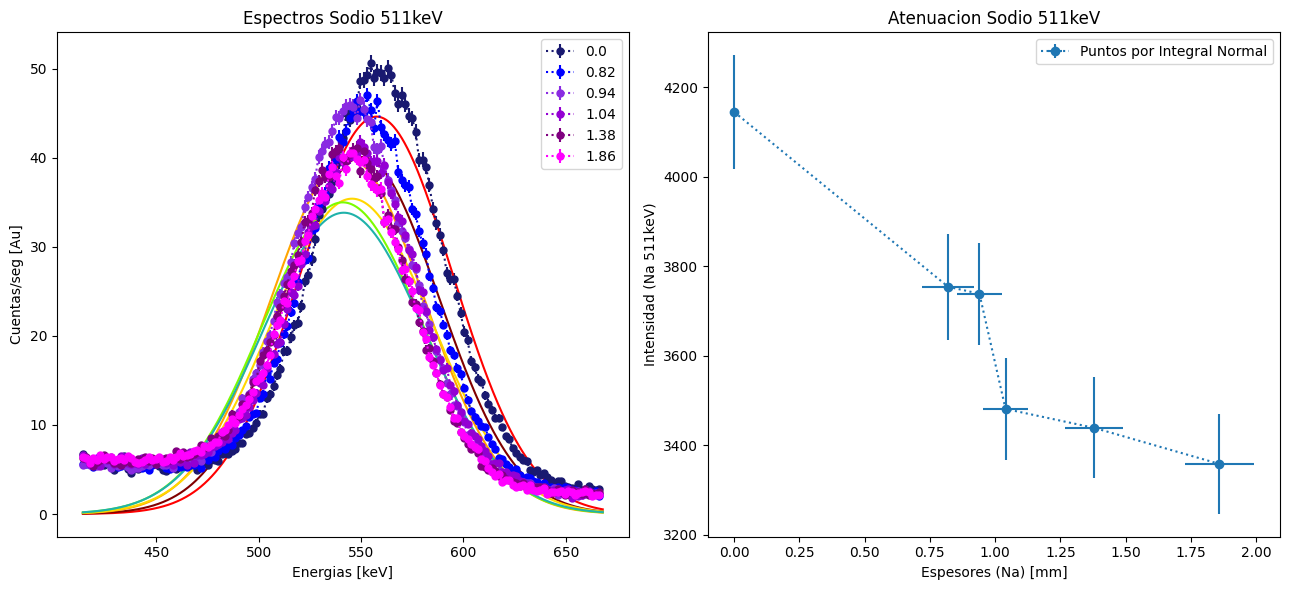

In [27]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Dom=np.linspace(Eje_Energia[250], Eje_Energia[400], 1000)

Int_Sodio_511_g=[]
List_err_Int_Na_511=[]
List_Esp_Na=[]

c=0

for esp in Na.keys():
    List_Esp_Na+=[esp]

Esp_Na=np.array(List_Esp_Na)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Na.keys():

    pop, cov= curve_fit(gauss, Eje_Energia[250:400], Na[esp][0][250:400], sigma=Na[esp][1][250:400], p0=[E_Na[0],2,1], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu_2=pop[0]
    sigma=pop[1]
    Const=pop[2]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[1], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Sodio_511_g.append(Int_g)

    #Error Calculo del area:
    err_Int_g=err_gauss(sigma, Const, err[1], err[2])
    List_err_Int_Na_511.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[250:400], Na[esp][0][250:400], yerr=Na[esp][1][250:400], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    ax1.plot(Dom, gauss(Dom, mu_2, sigma, Const), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Sodio 511keV')
ax1.legend()

ax2.errorbar(Esp_Na, np.array(Int_Sodio_511_g), yerr=np.array(List_err_Int_Na_511), xerr= Esp_Na_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Sodio 511keV')
ax2.set_xlabel('Espesores (Na) [mm]')
ax2.set_ylabel('Intensidad (Na 511keV)')
ax2.legend()

plt.tight_layout()
plt.show()

Segundo Pico

Espesor:  0.0 sigma=  59.31925766096671 +- 0.9435787031598224 Constante= 4.853564598231212
Espesor:  0.82 sigma=  58.176938922621716 +- 0.8040747383577498 Constante= 4.813691977462769
Espesor:  0.94 sigma=  57.85200670400594 +- 0.6932051726499928 Constante= 4.826709674451383
Espesor:  1.04 sigma=  58.655379790889356 +- 0.729471706199702 Constante= 4.446421391287969
Espesor:  1.38 sigma=  57.86031868400841 +- 0.7164871421771054 Constante= 4.427553395484598
Espesor:  1.86 sigma=  57.709612176496414 +- 0.713853237418674 Constante= 4.383057103181448


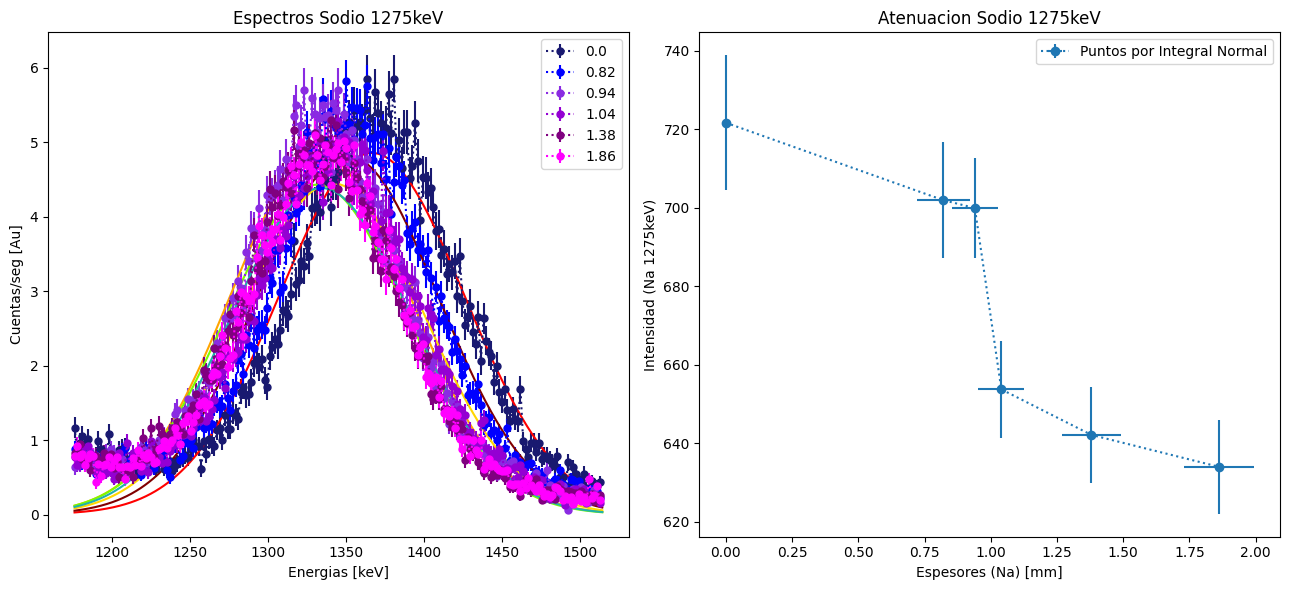

In [28]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Dom=np.linspace(Eje_Energia[700], Eje_Energia[900], 1000)

Int_Sodio_1275_g=[]
List_err_Int_Na_1275=[]
List_Esp_Na=[]

c=0

for esp in Na.keys():
    List_Esp_Na+=[esp]

Esp_Na=np.array(List_Esp_Na)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Na.keys():

    pop, cov= curve_fit(gauss, Eje_Energia[700:900], Na[esp][0][700:900], sigma=Na[esp][1][700:900],p0=[1400,2,1], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu_2=pop[0]
    sigma=pop[1]
    Const=pop[2]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[1], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Sodio_1275_g.append(Int_g)
    
    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[1], err[2])
    List_err_Int_Na_1275.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[700:900], Na[esp][0][700:900], yerr=Na[esp][1][700:900],fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    ax1.plot(Dom, gauss(Dom, mu_2, sigma, Const), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Sodio 1275keV')
ax1.legend()

ax2.errorbar(Esp_Na, np.array(Int_Sodio_1275_g), yerr=np.array(List_err_Int_Na_1275) ,xerr=Esp_Na_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Sodio 1275keV')
ax2.set_xlabel('Espesores (Na) [mm]')
ax2.set_ylabel('Intensidad (Na 1275keV)')
ax2.legend()

plt.tight_layout()
plt.show()

### Cesio

In [29]:
#Error Espesor
List_err_Esp_Cs=[]

for i in Cs.values():
    List_err_Esp_Cs.append(i[2])

Esp_Cs_err=np.array(List_err_Esp_Cs)
#--------------------------------------

Espesor:  0.0 sigma=  32.110262930531036 +- 0.3039542097571596 Constante= 2.072775757546385
Espesor:  1.0 sigma=  32.35625591069031 +- 0.32058880551312874 Constante= 1.9356938187951613
Espesor:  1.54 sigma=  32.51961227231419 +- 0.34418988493196556 Constante= 1.8308727132800056
Espesor:  4.17 sigma=  34.31952977945053 +- 0.4270868884112481 Constante= 1.5583064589245053
Espesor:  6.03 sigma=  34.06104725306221 +- 0.4416685557796485 Constante= 1.3917227224072328
Espesor:  7.53 sigma=  34.648924454296214 +- 0.5141293579098027 Constante= 1.294377824443958


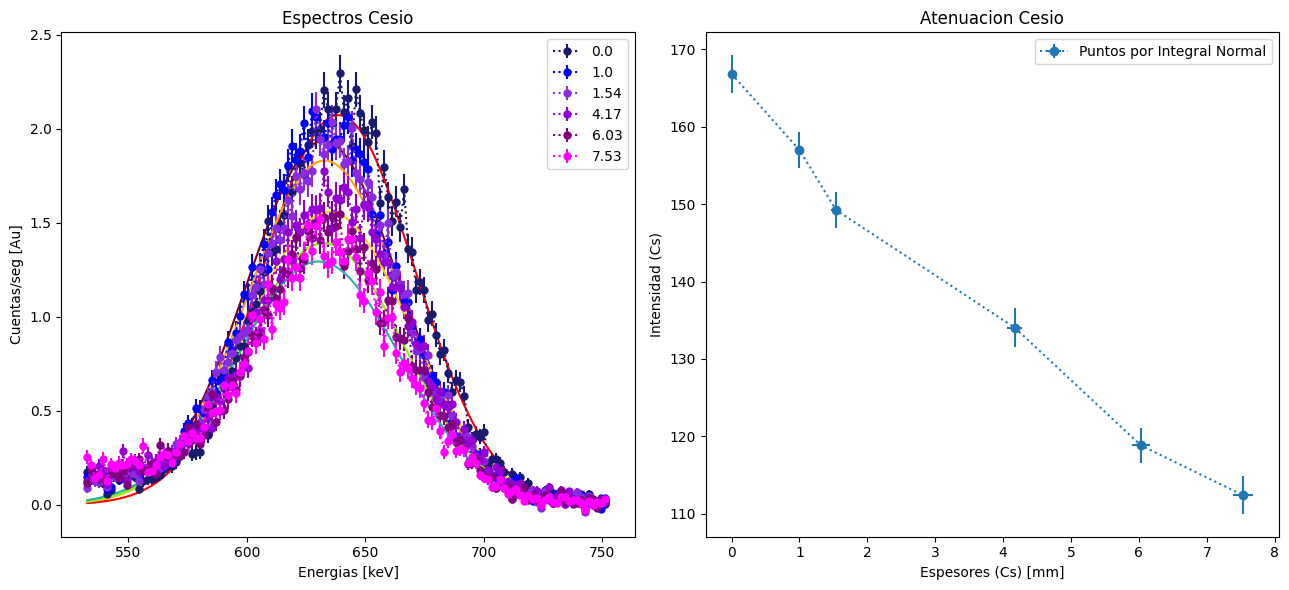

In [30]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Dom=np.linspace(Eje_Energia[320], Eje_Energia[450], 1000)

Int_Cesio_g=[]
List_err_Int_Cs=[]
List_Esp_Cs=[]

c=0

for esp in Cs.keys():
    List_Esp_Cs+=[esp]

Esp_Cs=np.array(List_Esp_Cs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Cs.keys():

    pop, cov= curve_fit(gauss, Eje_Energia[320:450], Cs[esp][0][320:450], sigma=Cs[esp][1][320:450], p0=[E_Cs[0],2,1], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu_2=pop[0]
    sigma=pop[1]
    Const=pop[2]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[1], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Cesio_g.append(Int_g)

    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[1], err[2])
    List_err_Int_Cs.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[320:450], Cs[esp][0][320:450], yerr=Cs[esp][1][320:450], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    ax1.plot(Dom, gauss(Dom, mu_2, sigma, Const), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Cesio')
ax1.legend()

ax2.errorbar(Esp_Cs, np.array(Int_Cesio_g), yerr=np.array(List_err_Int_Cs), xerr= Esp_Cs_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Cesio')
ax2.set_xlabel('Espesores (Cs) [mm]')
ax2.set_ylabel('Intensidad (Cs)')
ax2.legend()

plt.tight_layout()
plt.show()

### Cobalto

In [31]:
#Error Espesor
List_err_Esp_Co=[]

for i in Co.values():
    List_err_Esp_Co.append(i[2])

Esp_Co_err=np.array(List_err_Esp_Co)
#--------------------------------------

Primer Pico

Aca el pico de I0, (respectivo a espesor '0.00') no da, por eso lo saco.

Espesor:  0.0 sigma=  51.52836081564369 +- 1.384130850013901 Constante= 0.3126038641053258
Espesor:  4.38 sigma=  56.15475764485897 +- 1.3298937737296186 Constante= 0.27264079001951425
Espesor:  5.55 sigma=  58.150903507683154 +- 1.3514456039196925 Constante= 0.2552117620048959
Espesor:  7.08 sigma=  60.55140447159588 +- 1.6001304502862024 Constante= 0.23409872607671386
Espesor:  8.12 sigma=  63.27712664199609 +- 1.3919972809109582 Constante= 0.2226165313115138


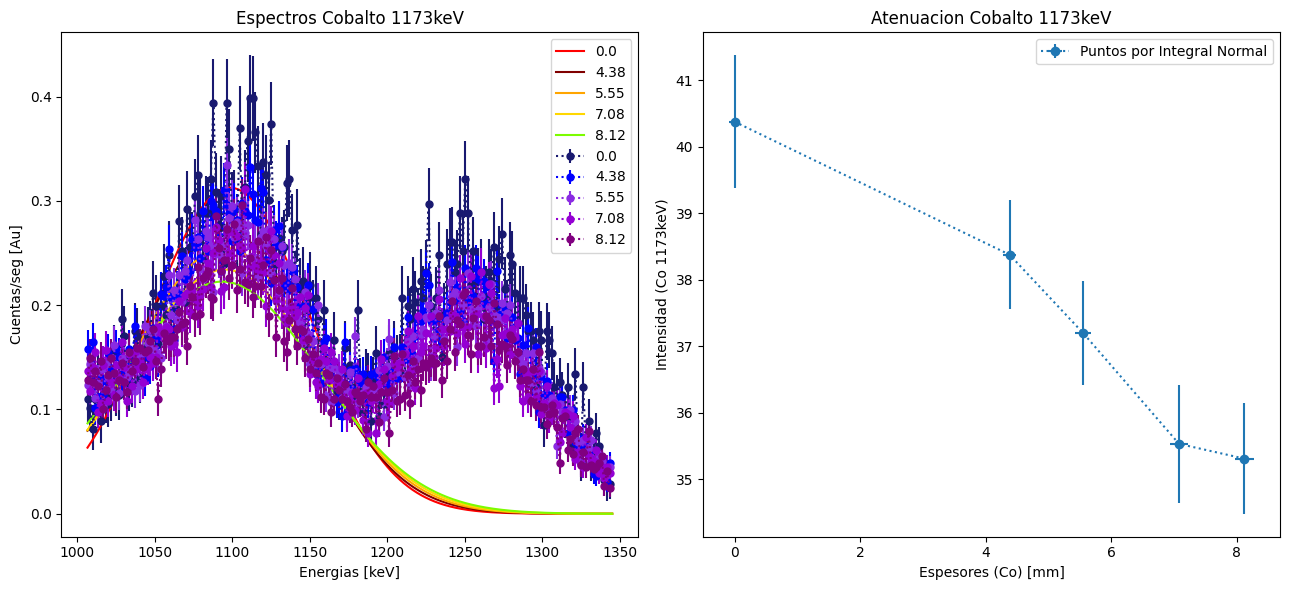

In [32]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Dom=np.linspace(Eje_Energia[600], Eje_Energia[800], 1000)

Int_Cobalto_1173_g=[]
List_err_Int_Co_1173=[]
List_Esp_Co_1173=[]

c=0

for esp in Co.keys():
    if esp!=2.55:

        List_Esp_Co_1173+=[esp]

Esp_Co_1173=np.array(List_Esp_Co_1173)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Co.keys():

    if esp!=2.55:

        pop, cov= curve_fit(Doble_gauss, Eje_Energia[600:800], Co[esp][0][600:800], sigma=Co[esp][1][600:800], p0=[1100,5,1,1300,2,1], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

        err=np.sqrt(np.diag(cov))

        mu=pop[0]
        sigma=pop[1]
        Const=pop[2]

        print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

        Int_g=Gauss_int(sigma, Const)
        Int_Cobalto_1173_g.append(Int_g)

        #Error Calculo del Area
        err_Int_g=err_gauss(sigma, Const, err[1], err[2])
        List_err_Int_Co_1173.append(err_Int_g)
        
        ax1.errorbar(Eje_Energia[600:800], Co[esp][0][600:800], yerr=Co[esp][1][600:800], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
        ax1.plot(Dom, gauss(Dom, mu, sigma, Const), color=Colores_plot[c], label=str(esp))
        c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Cobalto 1173keV')
ax1.legend()

ax2.errorbar(Esp_Co_1173, np.array(Int_Cobalto_1173_g), yerr=np.array(List_err_Int_Co_1173), xerr= Esp_Co_err[1:], fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Cobalto 1173keV')
ax2.set_xlabel('Espesores (Co) [mm]')
ax2.set_ylabel('Intensidad (Co 1173keV)')
ax2.legend()

plt.tight_layout()
plt.show()

Segundo Pico

Espesor:  0.0 sigma=  42.29952260565532 +- 1.384130850013901 Constante= 0.243484211356479
Espesor:  2.55 sigma=  44.94819146695593 +- 1.282232993296677 Constante= 0.21141951411551993
Espesor:  4.38 sigma=  44.144821103296294 +- 1.3298937737296186 Constante= 0.2046826175617535
Espesor:  5.55 sigma=  44.23308477452087 +- 1.3514456039196925 Constante= 0.19206494485687733
Espesor:  7.08 sigma=  43.830307518463506 +- 1.6001304502862024 Constante= 0.17666998207215584
Espesor:  8.12 sigma=  41.82775533628426 +- 1.3919972809109582 Constante= 0.1696310961657059


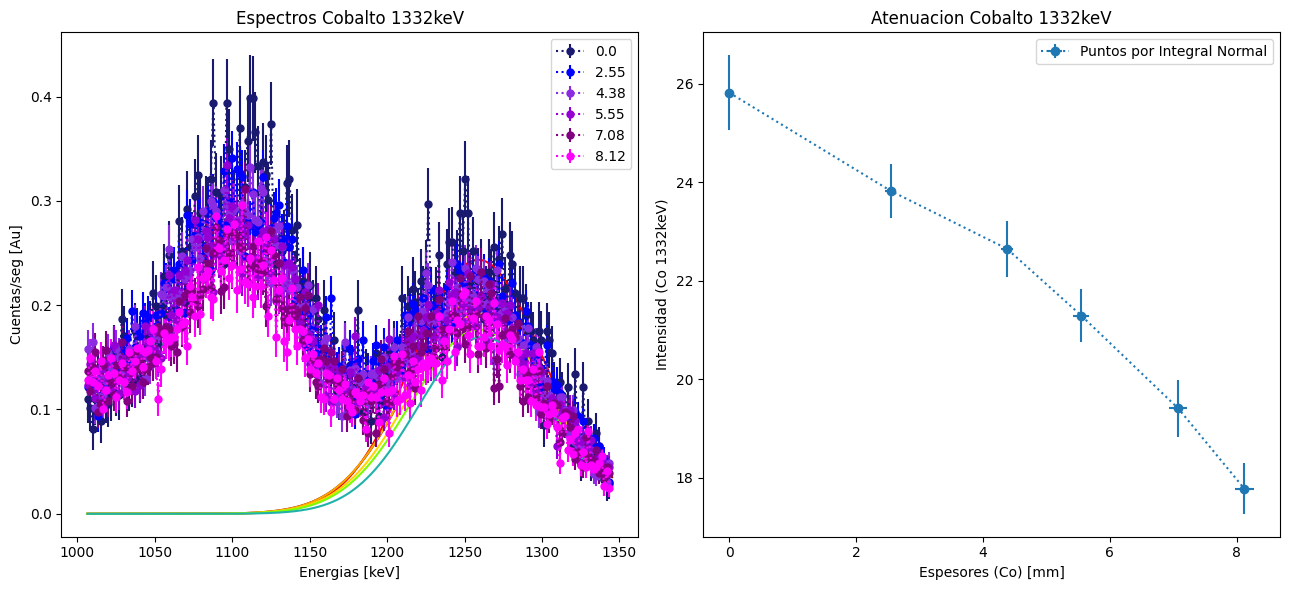

In [33]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Dom=np.linspace(Eje_Energia[600], Eje_Energia[800], 1000)

Int_Cobalto_1332_g=[]
List_err_Int_Co_1332=[]
List_Esp_Co_1332=[]

c=0

for esp in Co.keys():
    List_Esp_Co_1332+=[esp]

Esp_Co_1332=np.array(List_Esp_Co_1332)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Co.keys():

    pop, cov= curve_fit(Doble_gauss, Eje_Energia[600:800], Co[esp][0][600:800], sigma=Co[esp][1][600:800], p0=[1100,5,1,1300,2,1], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu=pop[3]
    sigma=pop[4]
    Const=pop[5]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Cobalto_1332_g.append(Int_g)

    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[4], err[5])
    List_err_Int_Co_1332.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[600:800], Co[esp][0][600:800], yerr=Co[esp][1][600:800], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    ax1.plot(Dom, gauss(Dom, mu, sigma, Const), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Cobalto 1332keV')
ax1.legend()

ax2.errorbar(Esp_Co_1332, np.array(Int_Cobalto_1332_g), yerr=np.array(List_err_Int_Co_1332), xerr= Esp_Co_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Cobalto 1332keV')
ax2.set_xlabel('Espesores (Co) [mm]')
ax2.set_ylabel('Intensidad (Co 1332keV)')
ax2.legend()

plt.tight_layout()
plt.show()

### Bario

In [34]:
#Error Espesor
List_err_Esp_Ba=[]

for i in Ba.values():
    List_err_Esp_Ba.append(i[2])

Esp_Ba_err=np.array(List_err_Esp_Ba)
#--------------------------------------

Primer Pico

Espesor:  0.0 sigma=  7.67296922287611 +- 0.8857549833130471 Constante= 361.4203652851292
Espesor:  0.13 sigma=  8.595414408711758 +- 0.5868286088897968 Constante= 142.15827985696865
Espesor:  0.21 sigma=  10.391689521500926 +- 0.5183221264852359 Constante= 76.28899210352074
Espesor:  0.33 sigma=  15.603054189478135 +- 0.39460720399499116 Constante= 37.382818322752975
Espesor:  0.78 sigma=  46.381231253516184 +- 0.32813375784206916 Constante= 23.660399382453157
Espesor:  1.54 sigma=  56.08051141749985 +- 0.3995054220570738 Constante= 17.981322735723705
Espesor:  2.9 sigma=  65.51866712212657 +- 0.716297307200645 Constante= 13.380954799214726
Espesor:  4.06 sigma=  76.04367442703237 +- 1.4753052929139983 Constante= 12.115307761252527


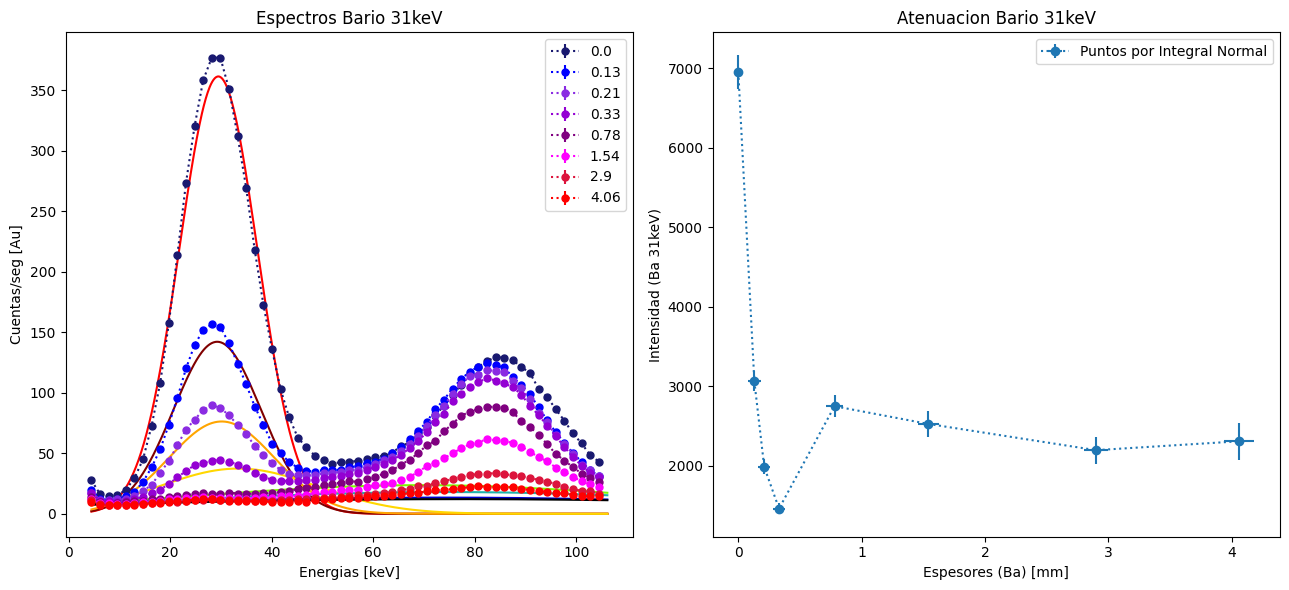

In [35]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue', 'black']
Dom=np.linspace(Eje_Energia[8], Eje_Energia[68], 800)

Int_Bario_31_g=[]
List_err_Int_Ba_31=[]
List_Esp_Ba=[]

c=0

for esp in Ba.keys():
    List_Esp_Ba+=[esp]

Esp_Ba=np.array(List_Esp_Ba)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Ba.keys():

    pop, cov= curve_fit(Doble_gauss, Eje_Energia[8:68], Ba[esp][0][8:68], sigma=Ba[esp][1][8:68], p0=[20,5,1,80,2,1], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu=pop[0]
    sigma=pop[1]
    Const=pop[2]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Bario_31_g.append(Int_g)

    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[1], err[2])
    List_err_Int_Ba_31.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[8:68], Ba[esp][0][8:68], yerr=Ba[esp][1][8:68], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    ax1.plot(Dom, gauss(Dom, mu, sigma, Const), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Bario 31keV')
ax1.legend()

ax2.errorbar(Esp_Ba, np.array(Int_Bario_31_g), yerr=np.array(List_err_Int_Ba_31), xerr= Esp_Ba_err,fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Bario 31keV')
ax2.set_xlabel('Espesores (Ba) [mm]')
ax2.set_ylabel('Intensidad (Ba 31keV)')
ax2.legend()

plt.tight_layout()
plt.show()

Segundo Pico

In [36]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue', 'black']
Dom=np.linspace(Eje_Energia[8], Eje_Energia[68], 800)

Int_Bario_81_g=[]
List_err_Int_Ba_81=[]
List_Esp_Ba_81=[]

c=0

for esp in Ba.keys():

    if esp!=4.06:

        List_Esp_Ba_81+=[esp]

Esp_Ba_81=np.array(List_Esp_Ba_81)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Ba.keys():
    
    if esp!=4.06:

        pop, cov= curve_fit(Doble_gauss, Eje_Energia[8:68], Ba[esp][0][8:68], sigma=Ba[esp][1][8:68], p0=[20,5,1,80,2,1], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

        err=np.sqrt(np.diag(cov))

        mu=pop[3]
        sigma=pop[4]
        Const=pop[5]

        print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

        Int_g=Gauss_int(sigma, Const)
        Int_Bario_81_g.append(Int_g)

        #Error Calculo del Area
        err_Int_g=err_gauss(sigma, Const, err[4], err[5])
        List_err_Int_Ba_81.append(err_Int_g)
        
        ax1.errorbar(Eje_Energia[8:68], Ba[esp][0][8:68], yerr=Ba[esp][1][8:68], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
        ax1.plot(Dom, gauss(Dom, mu, sigma, Const), color=Colores_plot[c])
        c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Bario 81keV')
ax1.legend()

ax2.errorbar(Esp_Ba_81, np.array(Int_Bario_81_g), yerr=np.array(List_err_Int_Ba_81), xerr=Esp_Ba_err[:7], fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Bario 81keV')
ax2.set_xlabel('Espesores (Ba) [mm]')
ax2.set_ylabel('Intensidad (Ba 81keV)')
ax2.legend()

plt.tight_layout()
plt.show()

Espesor:  0.0 sigma=  17.614143527753154 +- 0.8857549833130471 Constante= 111.63425143456618
Espesor:  0.13 sigma=  15.600943708072789 +- 0.5868286088897968 Constante= 110.54315975353198
Espesor:  0.21 sigma=  14.880526196432827 +- 0.5183221264852359 Constante= 108.65127482066278
Espesor:  0.33 sigma=  13.493797669368144 +- 0.39460720399499116 Constante= 106.24768311396507
Espesor:  0.78 sigma=  10.560788063681375 +- 0.32813375784206916 Constante= 65.69571239338181
Espesor:  1.54 sigma=  10.83967023827856 +- 0.3995054220570738 Constante= 42.83545227024191
Espesor:  2.9 sigma=  12.028003957522314 +- 0.716297307200645 Constante= 19.795963671422086


Tercer Pico

In [37]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue', 'black']
Dom=np.linspace(Eje_Energia[150], Eje_Energia[300], 1000)

Int_Bario_356_g=[]
List_err_Int_Ba_356=[]
List_Esp_Ba_356=[]

c=0

for esp in Ba.keys():
    List_Esp_Ba_356+=[esp]

Esp_Ba_356=np.array(List_Esp_Ba_356)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Ba.keys():

    pop, cov= curve_fit(Doble_gauss, Eje_Energia[150:300], Ba[esp][0][150:300], sigma=Ba[esp][1][150:300], p0=[300,15,30,400,15,80], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu_2=pop[3]
    sigma=pop[4]
    Const=pop[5]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Bario_356_g.append(Int_g)

    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[4], err[5])
    List_err_Int_Ba_356.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[150:300], Ba[esp][0][150:300], yerr=Ba[esp][1][150:300], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    # ax1.plot(Dom, gauss(Dom,pop[0], pop[1], pop[2]), color=Colores_plot[c])
    ax1.plot(Dom, gauss(Dom,pop[3], pop[4], pop[5]), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Bario 356keV')
ax1.legend()

ax2.errorbar(Esp_Ba_356, np.array(Int_Bario_356_g), yerr=np.array(List_err_Int_Ba_356),xerr= Esp_Ba_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Bario 356keV')
ax2.set_xlabel('Espesores (Ba 356keV) [mm]')
ax2.set_ylabel('Intensidad (Ba 356keV)')
ax2.legend()

plt.tight_layout()
plt.show()

Espesor:  0.0 sigma=  21.048015281359916 +- 0.37872113596187296 Constante= 32.68560601775138
Espesor:  0.13 sigma=  19.913694064252205 +- 0.3369300972249474 Constante= 32.155171341335084
Espesor:  0.21 sigma=  19.889798063780322 +- 0.344444468440793 Constante= 32.448019292895296
Espesor:  0.33 sigma=  19.891643218374195 +- 0.34903805317000375 Constante= 31.808997085039202
Espesor:  0.78 sigma=  19.945302862174653 +- 0.3492653323232658 Constante= 30.986181088319995
Espesor:  1.54 sigma=  20.286851984041636 +- 0.3096078006366512 Constante= 29.668431473185723
Espesor:  2.9 sigma=  20.4949440191499 +- 0.3341483145331571 Constante= 27.52810601611502
Espesor:  4.06 sigma=  20.51626221463002 +- 0.2904217390233559 Constante= 25.478212681525058


### Americio

In [38]:
#Error Espesor
List_err_Esp_Am=[]

for i in Am.values():
    List_err_Esp_Am.append(i[2])

Esp_Am_err=np.array(List_err_Esp_Am)
#--------------------------------------

Espesor:  0.0 sigma=  9.044949444045084 +- 0.05039574631876555 Constante= 169.53557914224908
Espesor:  0.13 sigma=  8.88450281737835 +- 0.062335566731612974 Constante= 147.01016522033052
Espesor:  0.32 sigma=  8.843845307284322 +- 0.05618957990188888 Constante= 114.01625533441755
Espesor:  0.72 sigma=  8.854092778154532 +- 0.05840023982462042 Constante= 66.91572841176014
Espesor:  1.1 sigma=  8.946690033328702 +- 0.057066926733889925 Constante= 40.077571041731
Espesor:  1.34 sigma=  9.036372087922954 +- 0.055443882073003666 Constante= 30.003711424643523


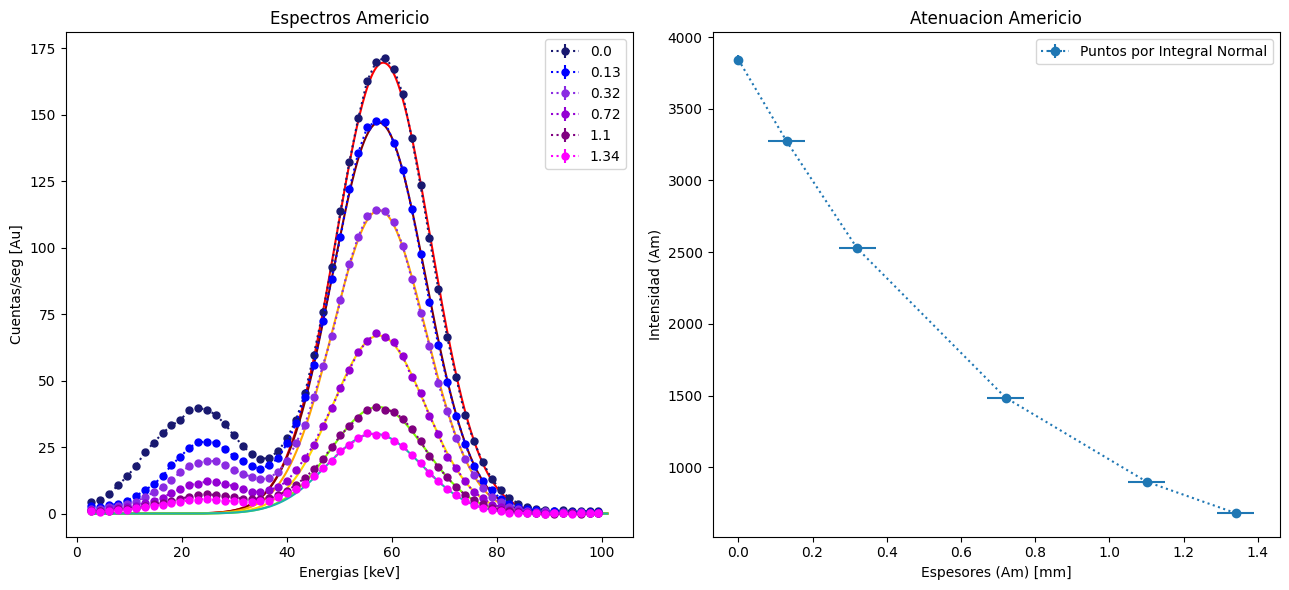

In [39]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Dom=np.linspace(Eje_Energia[7], Eje_Energia[65], 1000)

Int_Americio_g=[]
List_err_Int_Am=[]
List_Esp_Am=[]

c=0

for esp in Am.keys():
    List_Esp_Am+=[esp]
    List_err_Esp_Am.append(Am[esp][2])

Esp_Am=np.array(List_Esp_Am)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for esp in Am.keys():

    pop, cov= curve_fit(Doble_gauss, Eje_Energia[7:65], Am[esp][0][7:65], sigma=Am[esp][1][7:65], p0=[22,5,1,E_Am[0],2,1], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu_2=pop[3]
    sigma=pop[4]
    Const=pop[5]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Americio_g.append(Int_g)

    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[4], err[5])
    List_err_Int_Am.append(err_Int_g)
    
    ax1.errorbar(Eje_Energia[7:65], Am[esp][0][7:65], yerr=Am[esp][1][7:65], fmt='o:', markersize= 5, color=Colores[c], label=str(esp)) 
    ax1.plot(Dom, gauss(Dom, mu_2, sigma, Const), color=Colores_plot[c])
    c=c+1

ax1.set_xlabel('Energias [keV]')
ax1.set_ylabel('Cuentas/seg [Au]')
ax1.set_title('Espectros Americio')
ax1.legend()

ax2.errorbar(Esp_Am, np.array(Int_Americio_g),yerr=np.array(List_err_Int_Am), xerr=Esp_Am_err, fmt='o:', label='Puntos por Integral Normal')
ax2.set_title('Atenuacion Americio')
ax2.set_xlabel('Espesores (Am) [mm]')
ax2.set_ylabel('Intensidad (Am)')
ax2.legend()

plt.tight_layout()
plt.show()

In [113]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']
Marcadores_plot=['s', 'h', '^', '*', 'd', 'o','x']
Label_Espesores=['0.0 [mm]', '0.13 [mm]', '0.32 [mm]', '0.72 [mm]', '1.1 [mm]', '1.34 [mm]']
Label_Int=['Intensidad (0.00 [mm])', 'Intensidad (0.13 [mm])', 'Intensidad (0.32 [mm])', 'Intensidad (0.72 [mm])', 'Intensidad (1.10 [mm])', 'Intensidad (1.34 [mm])']



Dom=np.linspace(Eje_Energia[7], Eje_Energia[65], 1000)

Int_Americio_g=[]
List_err_Int_Am=[]
List_Esp_Am=[]

c=0

for esp in Am.keys():
    List_Esp_Am+=[esp]
    List_err_Esp_Am.append(Am[esp][2])

Esp_Am=np.array(List_Esp_Am)

plt.figure(figsize=(10, 6))

for esp in Am.keys():

    pop, cov= curve_fit(Doble_gauss, Eje_Energia[7:65], Am[esp][0][7:65], sigma=Am[esp][1][7:65], p0=[22,5,1,E_Am[0],2,1], bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

    err=np.sqrt(np.diag(cov))

    mu_2=pop[3]
    sigma=pop[4]
    Const=pop[5]

    print('Espesor: ', esp, 'sigma= ', sigma, '+-', err[4], 'Constante=', Const)

    Int_g=Gauss_int(sigma, Const)
    Int_Americio_g.append(Int_g)

    #Error Calculo del Area
    err_Int_g=err_gauss(sigma, Const, err[4], err[5])
    List_err_Int_Am.append(err_Int_g)
    
    plt.errorbar(Eje_Energia[7:65], Am[esp][0][7:65], yerr=Am[esp][1][7:65], fmt=Marcadores_plot[c], markersize= 5, color=Colores[c], label=Label_Espesores[c]) 
    
    plt.plot(Dom, gauss(Dom, mu_2, sigma, Const), color=Colores_plot[c])
    plt.fill_between(Dom, gauss(Dom, mu_2, sigma, Const), color=Colores_plot[c], alpha=0.3, label=Label_Int[c])
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Espectros Americio')
plt.grid()
plt.legend()

plt.savefig('Espectros_Americio.jpg', format='jpg', dpi=300)

plt.show()


Espesor:  0.0 sigma=  9.044949444045084 +- 0.05039574631876555 Constante= 169.53557914224908
Espesor:  0.13 sigma=  8.88450281737835 +- 0.062335566731612974 Constante= 147.01016522033052
Espesor:  0.32 sigma=  8.843845307284322 +- 0.05618957990188888 Constante= 114.01625533441755
Espesor:  0.72 sigma=  8.854092778154532 +- 0.05840023982462042 Constante= 66.91572841176014
Espesor:  1.1 sigma=  8.946690033328702 +- 0.057066926733889925 Constante= 40.077571041731
Espesor:  1.34 sigma=  9.036372087922954 +- 0.055443882073003666 Constante= 30.003711424643523


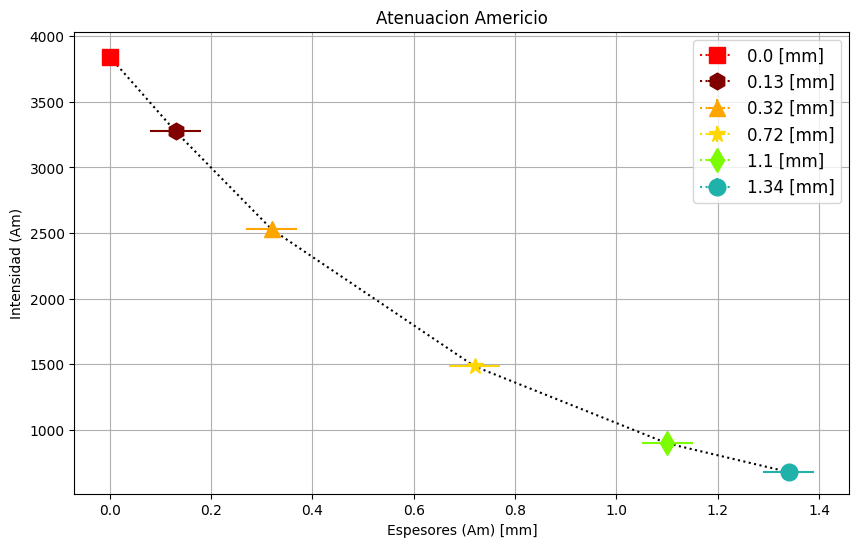

In [115]:
Colores_plot=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen']
Marcadores_plot=['s:', 'h:', '^:', '*:', 'd:', 'o:','x:']

plt.figure(figsize=(10, 6))

for n in range(0,6,1):
    plt.errorbar(Esp_Am[n], np.array(Int_Americio_g)[n],yerr=np.array(List_err_Int_Am)[n], xerr=Esp_Am_err[n], fmt=Marcadores_plot[n], label=Label_Espesores[n], color=Colores_plot[n], markersize=12)

plt.plot(Esp_Am, Int_Americio_g, linestyle=':', color='black')
plt.title('Atenuacion Americio')
plt.xlabel('Espesores (Am) [mm]')
plt.ylabel('Intensidad (Am)')
plt.grid()
plt.legend(fontsize='12')

plt.savefig('atenuacion_americio.jpg', format='jpg', dpi=300)

plt.show()

## Sumas Riemann

### Sodio

In [40]:
c=0
for esp in Na.keys():
    plt.errorbar(canales[10:], Na[esp][0][10:], fmt='.:', color=Colores[c], label=str(esp))  
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Atenuacion Sodio')
plt.xlim(250,400)
plt.legend()
plt.show()

 Primer Pico 511 keV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


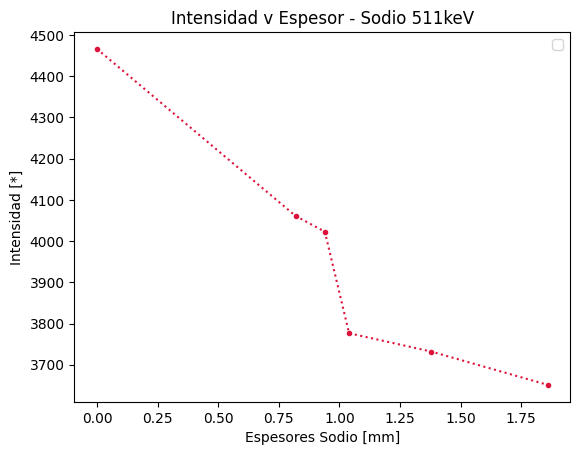

In [41]:
List_I_Na_511=[]
List_Esp_Na=[]

for esp in Na.keys():

    Int=Suma_Riemann(Eje_Energia, Na[esp][0], 250,400)
    List_I_Na_511+= [Int]
    List_Esp_Na+=[esp]

I_Na_511=np.array(List_I_Na_511)
Esp_Na=np.array(List_Esp_Na)

plt.errorbar(Esp_Na, I_Na_511, fmt='.:', color='crimson')
plt.xlabel('Espesores Sodio [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Sodio 511keV')
plt.legend()
plt.show()

### Bario

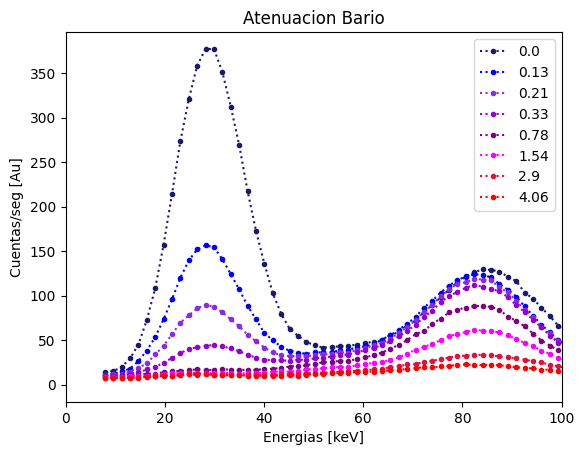

In [42]:
c=0
for esp in Ba.keys():
    plt.errorbar(Eje_Energia[10:], Ba[esp][0][10:], fmt='.:', color=Colores[c], label=str(esp))  
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Atenuacion Bario')
plt.xlim(0,100)
plt.legend()
plt.show()

 Primer Pico 31 keV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


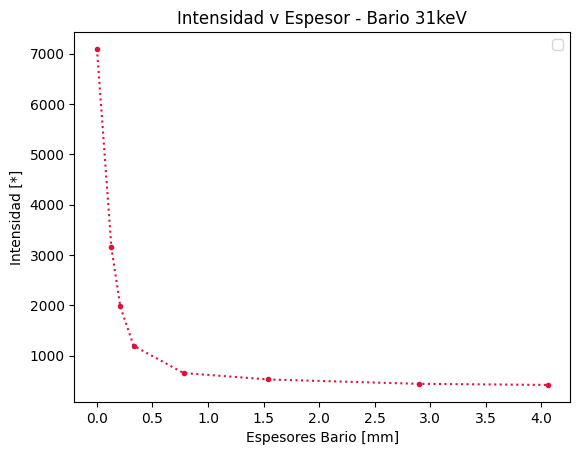

In [43]:
#Primer Pico 31keV

List_I_Ba_31=[]
List_Esp_Ba=[]

for esp in Ba.keys():

    Int=Suma_Riemann(Eje_Energia, Ba[esp][0], 10, 35)
    List_I_Ba_31+= [Int]
    List_Esp_Ba+=[esp]

I_Ba_31=np.array(List_I_Ba_31)
Esp_Ba=np.array(List_Esp_Ba)

plt.errorbar(Esp_Ba, I_Ba_31, fmt='.:', color='crimson')
plt.xlabel('Espesores Bario [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Bario 31keV')
plt.legend()
plt.show()

Segundo Pico 81 keV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


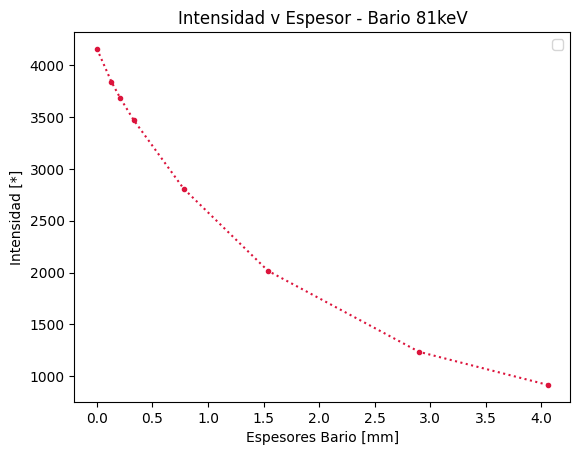

In [44]:
#Segundo Pico 81 keV

List_I_Ba_81=[]
List_Esp_Ba=[]

for esp in Ba.keys():

    Int=Suma_Riemann(Eje_Energia, Ba[esp][0], 40,70)
    List_I_Ba_81+= [Int]
    List_Esp_Ba+=[esp]

I_Ba_81=np.array(List_I_Ba_81)
Esp_Ba=np.array(List_Esp_Ba)

plt.errorbar(Esp_Ba, I_Ba_81, fmt='.:', color='crimson')
plt.xlabel('Espesores Bario [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Bario 81keV')
plt.legend()
plt.show()

Tercer Pico 356 keV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


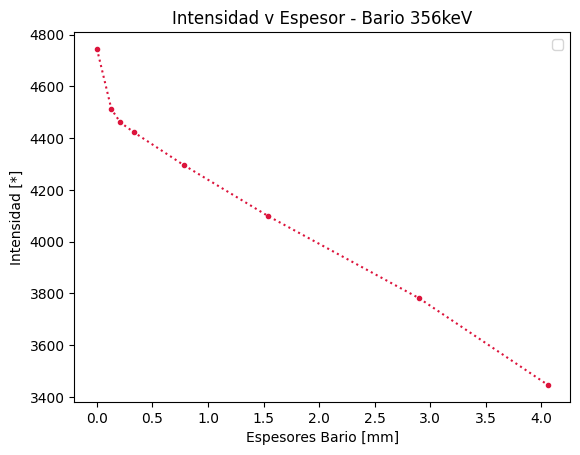

In [45]:
#Segundo Pico 81 keV

List_I_Ba_356=[]
List_Esp_Ba=[]

for esp in Ba.keys():

    Int=Suma_Riemann(Eje_Energia, Ba[esp][0], 175,265)
    List_I_Ba_356+= [Int]
    List_Esp_Ba+=[esp]

I_Ba_356=np.array(List_I_Ba_356)
Esp_Ba=np.array(List_Esp_Ba)

plt.errorbar(Esp_Ba, I_Ba_356, fmt='.:', color='crimson')
plt.xlabel('Espesores Bario [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Bario 356keV')
plt.legend()
plt.show()

### Cobalto

In [46]:
c=0
for esp in Co.keys():
    plt.errorbar(Eje_Energia[10:], Co[esp][0][10:], fmt='.:', color=Colores[c], label=str(esp))  
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Atenuacion Cobalto')
plt.xlim(1050,1450)
plt.legend()
plt.show()


Primer Pico 1173keV

In [47]:
List_I_Co_1173=[]
List_Esp_Co=[]

for esp in Co.keys():

    Int=Suma_Riemann(Eje_Energia, Co[esp][0], 610,700)
    List_I_Co_1173+= [Int]
    List_Esp_Co+=[esp]

I_Co_1173=np.array(List_I_Co_1173)
Esp_Co=np.array(List_Esp_Co)

plt.errorbar(Esp_Co, I_Co_1173, fmt='.:', color='crimson')
plt.xlabel('Espesores Cobalto [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Cobalto 1173keV')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Segundo Pico 1332 keV

In [48]:
List_I_Co_1332=[]
List_Esp_Co=[]

for esp in Co.keys():

    Int=Suma_Riemann(Eje_Energia, Co[esp][0], 705,790)
    List_I_Co_1332+= [Int]
    List_Esp_Co+=[esp]

I_Co_1332=np.array(List_I_Co_1332)
Esp_Co=np.array(List_Esp_Co)

plt.errorbar(Esp_Co, I_Co_1332, fmt='.:', color='crimson')
plt.xlabel('Espesores Cobalto [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Cobalto 1332keV')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


### Americio

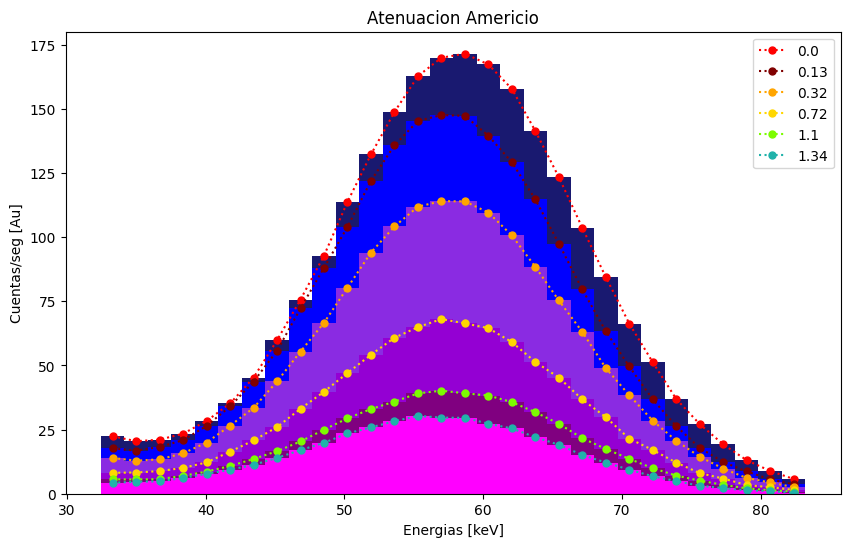

In [49]:
Colores_histo=['red', 'maroon','orange', 'gold', 'lawngreen', 'lightseagreen', 'mediumblue']

c=0

plt.figure(figsize=(10, 6))

for esp in Am.keys():
    plt.errorbar(Eje_Energia[25:55], Am[esp][0][25:55], fmt='o:', markersize= 5, color=Colores_histo[c], label=str(esp))
    plt.bar(Eje_Energia[25:55],Am[esp][0][25:55], width=1.7, color=Colores[c]) 
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Atenuacion Americio')
plt.legend()
plt.show()

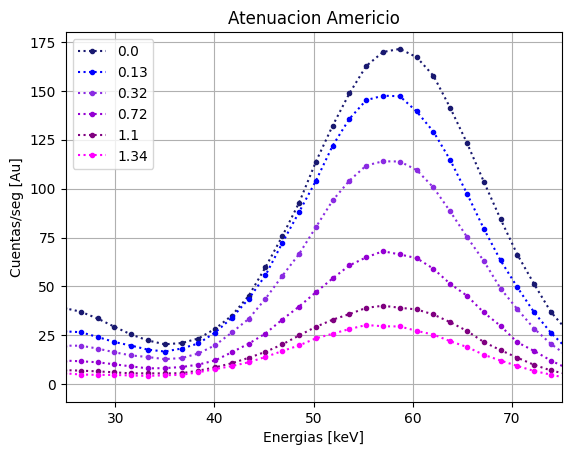

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


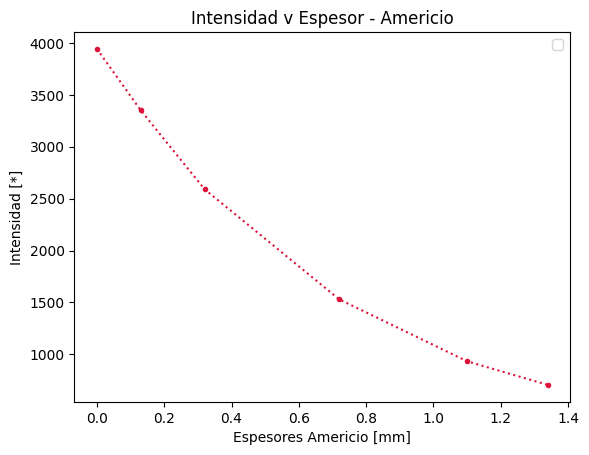

In [50]:
c=0
for esp in Am.keys():
    plt.errorbar(Eje_Energia[10:], Am[esp][0][10:], fmt='.:', color=Colores[c], label=str(esp))  
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Atenuacion Americio')
plt.xlim(25,75)
plt.grid()
plt.legend()
plt.show()

List_I_Am=[]
List_Esp_Am=[]

for esp in Am.keys():

    Int=Suma_Riemann(Eje_Energia, Am[esp][0], 25,55)
    List_I_Am+= [Int]
    List_Esp_Am+=[esp]

I_Am=np.array(List_I_Am)
Esp_Am=np.array(List_Esp_Am)

plt.errorbar(Esp_Am, I_Am, fmt='.:', color='crimson')
plt.xlabel('Espesores Americio [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Americio')
plt.legend()
plt.show()

### Cesio

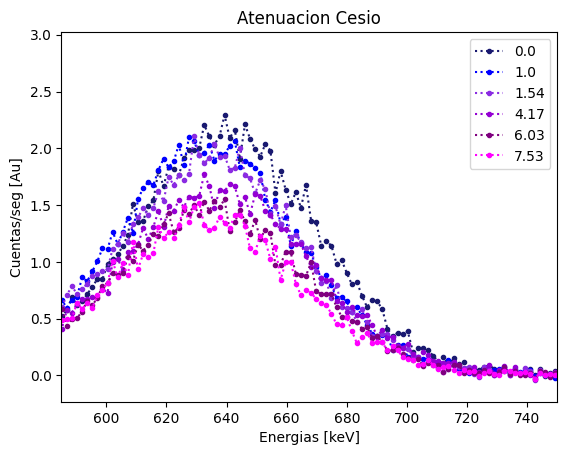

In [51]:
c=0

for esp in Cs.keys():
    plt.errorbar(Eje_Energia[10:], Cs[esp][0][10:], fmt='.:', color=Colores[c], label=str(esp))  
    c=c+1

plt.xlabel('Energias [keV]')
plt.ylabel('Cuentas/seg [Au]')
plt.title('Atenuacion Cesio')
plt.xlim(585,750)
plt.legend()
plt.show()

In [52]:
List_I_Cs=[]
List_Esp_Cs=[]

for esp in Cs.keys():

    Int=Suma_Riemann(Eje_Energia, Cs[esp][0], 325,440)
    List_I_Cs+= [Int]
    List_Esp_Cs+=[esp]

I_Cs=np.array(List_I_Cs)
Esp_Cs=np.array(List_Esp_Cs)

plt.errorbar(Esp_Cs, I_Cs, fmt='.:', color='crimson')
plt.xlabel('Espesores Cesio [mm]')
plt.ylabel('Intensidad [*]')
plt.title('Intensidad v Espesor - Cesio')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# Lambert -  Beer

## Por Integral Normal

In [53]:
def L_B(d, mu_l, C):

    I_I0=np.exp(-mu_l*d)+C
    return I_I0

In [54]:
Int_s=[Int_Americio_g, Int_Bario_81_g, Int_Bario_356_g, Int_Cesio_g, Int_Cobalto_1173_g, Int_Cobalto_1332_g]

Espesores_Int= [Esp_Am, Esp_Ba_81, Esp_Ba_356, Esp_Cs, Esp_Co_1173, Esp_Co_1332]

Int_I0=[]

for i in Int_s:

    for j in range(len(i)):

        I_I0=i[j]/i[0]
        Int_I0.append(I_I0)

sublistas_Int = []
temp_lista_Int = []

for valor in Int_I0:
    if valor == 1.0:
        if temp_lista_Int:
            sublistas_Int.append(temp_lista_Int)
            temp_lista_Int = []
        temp_lista_Int.insert(0, valor) # Inserta el valor 1.0 al principio de la sublista
    else:
        temp_lista_Int.append(valor)

# Añadir la última sublista si no está vacía
if temp_lista_Int:
    sublistas_Int.append(temp_lista_Int)


#Int_I0_Ba_31=np.array(sublistas_Int[0]) #0
Int_I0_Am_Int=np.array(sublistas_Int[0]) #1
Int_I0_Ba_81_Int=np.array(sublistas_Int[1]) #2
Int_I0_Ba_356_Int=np.array(sublistas_Int[2]) #3
Int_I0_Cs_Int=np.array(sublistas_Int[3]) #4
Int_I0_Co_1173_Int=np.array(sublistas_Int[4]) #5
Int_I0_Co_1332_Int=np.array(sublistas_Int[5]) #6
#Int_I0_Na_511_Int=np.array(sublistas_Int[7]) #7

1.3262536305369528 0.0040125318038818185
0.01905519177739664 0.003884406844238893


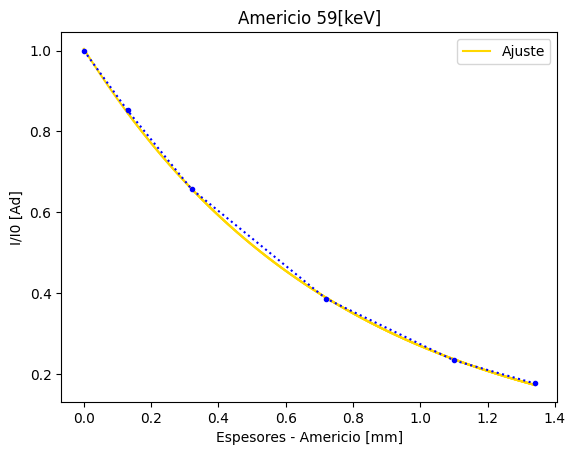

1.2741954764505519 0.04766119937853041
0.2042429902028144 0.036234496631106845


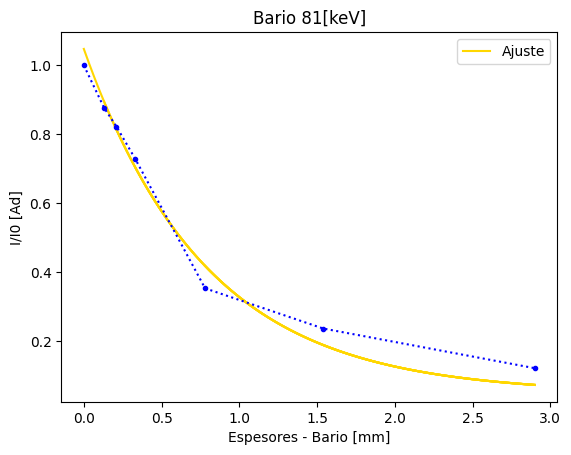

0.05315383738873379 -0.045849907044638705
0.006929391411971147 0.010852495487517145


0.051836698107610824 -0.010267413964558533
0.002788389293542676 0.008791400905951364


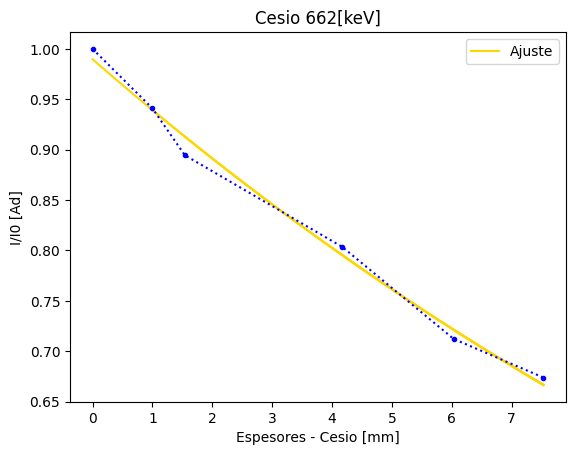

0.017197193435922183 0.006971938806674435
0.002321762188845551 0.0118892365693061


0.04341828244773584 0.019918916490993924
0.005719937769407235 0.023002223361361877


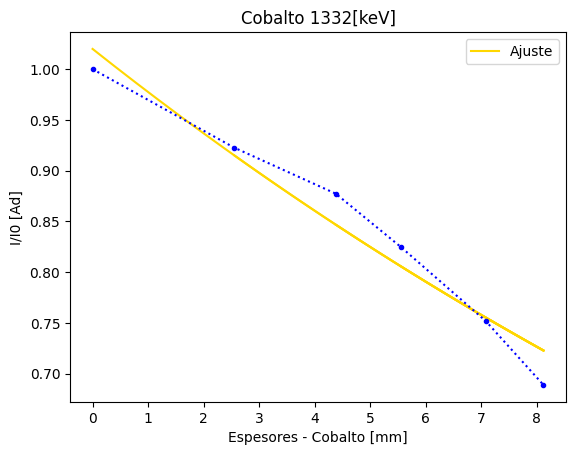

In [55]:
Mu_L_Int=[]
err_Mu_L_Int=[]
Energias_mu_Int=np.array([59. ,   81. ,  356. , 662. ,  1173, 1332])

Espesores_nom_Int=['Espesores - Americio [mm]','Espesores - Bario [mm]','Espesores - Bario [mm]','Espesores - Cesio [mm]','Espesores - Cobalto [mm]','Espesores - Cobalto [mm]']
Titulos_Int=['Americio 59[keV]','Bario 81[keV]','Bario 356[keV]','Cesio 662[keV]','Cobalto 1173[keV]','Cobalto 1332[keV]']

n = 0

for lista_int in sublistas_Int:
    
    array = np.array(lista_int)
    pop, cov = curve_fit(L_B, Espesores_Int[n], array)
    err = np.diag(np.sqrt(cov))

    print(pop[0], pop[1])
    print(err[0], err[1])

    Mu_L_Int.append(pop[0])
    err_Mu_L_Int.append(err[0])

    continuo = np.linspace(Espesores_Int[n], Espesores_Int[n][len(Espesores_Int[n])-1], 1000)

    plt.errorbar(Espesores_Int[n], array, fmt='.:', color='blue')
    plt.plot(continuo, L_B(continuo, pop[0], pop[1]), color='gold', label='Ajuste')
    plt.xlabel(Espesores_nom_Int[n])
    plt.ylabel('I/I0 [Ad]')
    plt.title(Titulos_Int[n])

    # Obtén los handles y labels actuales
    handles, labels = plt.gca().get_legend_handles_labels()
    # Crea un diccionario ordenado para almacenar los labels únicos
    by_label = OrderedDict(zip(labels, handles))
    # Pasa los valores y keys únicos al legend
    plt.legend(by_label.values(), by_label.keys())

    plt.show()
    n = n + 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


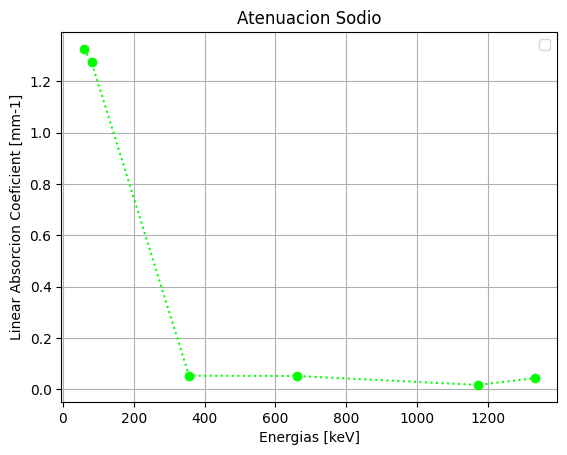

In [56]:
plt.errorbar(Energias_mu_Int,np.array(Mu_L_Int), fmt='o:', color='lime')
plt.xlabel('Energias [keV]')
plt.ylabel('Linear Absorcion Coeficient [mm-1]')
plt.title('Atenuacion Sodio')
plt.grid()
plt.legend()
plt.show()

## Por sumas de Riemann

Paso todas  las intensidades a su cociente con I0 respectivo:

In [57]:
I_s=[I_Ba_31, I_Am, I_Ba_81, I_Ba_356, I_Cs, I_Co_1173,I_Co_1332]
Espesores= [Esp_Ba, Esp_Am, Esp_Ba, Esp_Ba, Esp_Cs, Esp_Co, Esp_Co]

I_I0_s=[]

for i in I_s:

    for j in range(len(i)):

        I_I0=i[j]/i[0]
        I_I0_s.append(I_I0)

sublistas = []
temp_lista = []

for valor in I_I0_s:
    if valor == 1.0:
        if temp_lista:
            sublistas.append(temp_lista)
            temp_lista = []
        temp_lista.insert(0, valor) # Inserta el valor 1.0 al principio de la sublista
    else:
        temp_lista.append(valor)

# Añadir la última sublista si no está vacía
if temp_lista:
    sublistas.append(temp_lista)


I_I0_Ba_31=np.array(sublistas[0]) #0
I_I0_Am=np.array(sublistas[1]) #1
I_I0_Ba_81=np.array(sublistas[2]) #2
I_I0_Ba_356=np.array(sublistas[3]) #3
I_I0_Cs=np.array(sublistas[4]) #4
I_I0_Co_1173=np.array(sublistas[5]) #5
I_I0_Co_1332=np.array(sublistas[6]) #6
#I_I0_Na_511=np.array(sublistas[7]) #7

7.129508200112507 0.057482041935200165
0.47365893847268686 0.012808092858765881


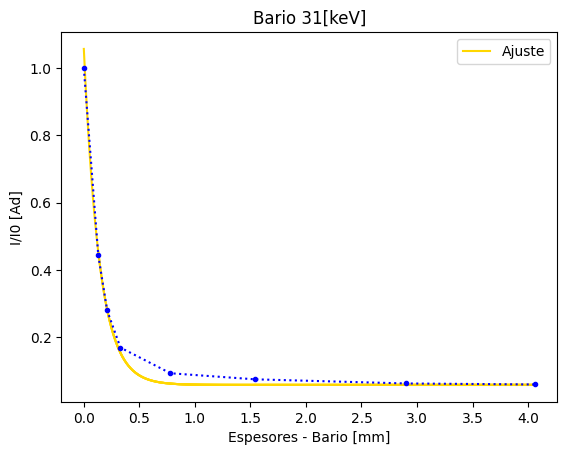

1.316349202533247 0.0028747191251436393
0.016451153672950303 0.0033819364542445893


0.400687703737578 -0.025172696676726017
0.03127695010894367 0.017872002946271164


0.0672615740383116 -0.03414858243577504
0.005411787366366122 0.00809044841780692


0.05083813258994307 -0.01130500010152927
0.002811955133768356 0.008919939699795607


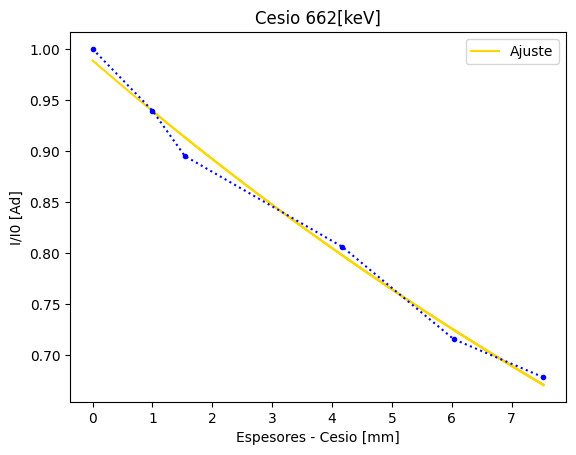

0.03275830705232877 0.017304115660468113
0.0032668570021039726 0.014087151849883428


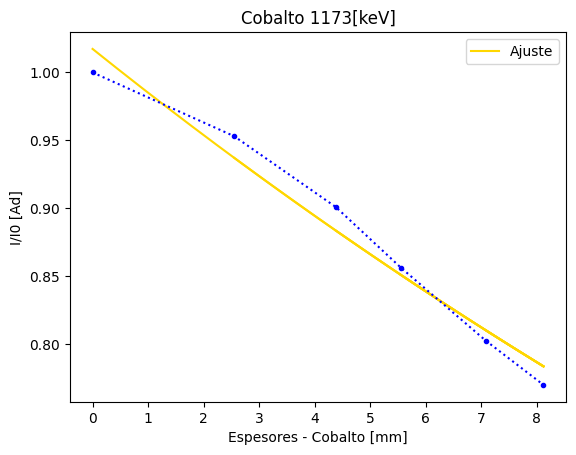

0.036884831935951004 0.009542267176272745
0.0023086113781937137 0.009688977257414157


In [58]:
Mu_L=[]
err_Mu_L=[]
Energias_mu=np.array([31. , 59. ,   81. ,  356. , 662. ,  1173, 1332])

Espesores_nom=['Espesores - Bario [mm]','Espesores - Americio [mm]','Espesores - Bario [mm]','Espesores - Bario [mm]','Espesores - Cesio [mm]','Espesores - Cobalto [mm]','Espesores - Cobalto [mm]']
Titulos=['Bario 31[keV]','Americio 59[keV]','Bario 81[keV]','Bario 356[keV]','Cesio 662[keV]','Cobalto 1173[keV]','Cobalto 1332[keV]']

n = 0

for lista_int in sublistas:
    
    array = np.array(lista_int)
    pop, cov = curve_fit(L_B, Espesores[n], array)
    err = np.diag(np.sqrt(cov))

    print(pop[0], pop[1])
    print(err[0], err[1])

    Mu_L.append(pop[0])
    err_Mu_L.append(err[0])

    continuo = np.linspace(Espesores[n], Espesores[n][len(Espesores[n])-1], 1000)

    plt.errorbar(Espesores[n], array, fmt='.:', color='blue')
    plt.plot(continuo, L_B(continuo, pop[0], pop[1]), color='gold', label='Ajuste')
    plt.xlabel(Espesores_nom[n])
    plt.ylabel('I/I0 [Ad]')
    plt.title(Titulos[n])

    # Obtén los handles y labels actuales
    handles, labels = plt.gca().get_legend_handles_labels()
    # Crea un diccionario ordenado para almacenar los labels únicos
    by_label = OrderedDict(zip(labels, handles))
    # Pasa los valores y keys únicos al legend
    plt.legend(by_label.values(), by_label.keys())

    plt.show()
    n = n + 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


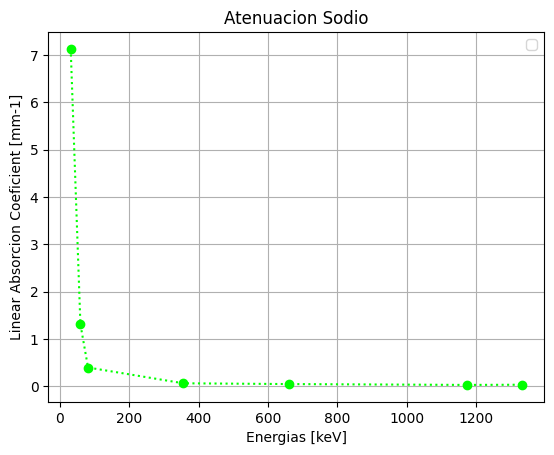

In [59]:
plt.errorbar(Energias_mu,np.array(Mu_L), fmt='o:', color='lime')
plt.xlabel('Energias [keV]')
plt.ylabel('Linear Absorcion Coeficient [mm-1]')
plt.title('Atenuacion Sodio')
plt.grid()
plt.legend()
plt.show()

1.6870305349091177
[0.00316844]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


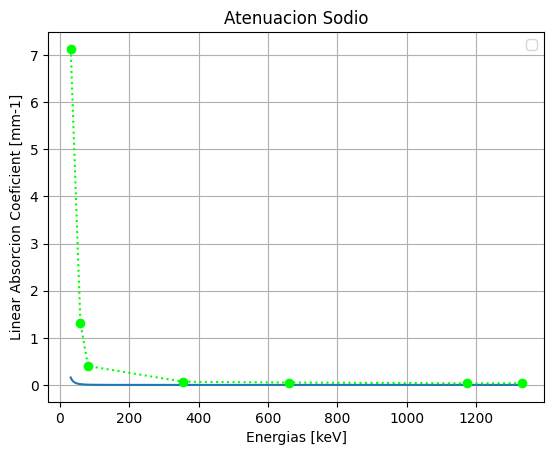

In [60]:
def Ef_ph(E, A):
    sig=A*(29**4)/(E**3.5)
    return sig

pop_ph, cov_ph= curve_fit(Ef_ph, Energias_mu, np.array(Mu_L))

err_ph=np.sqrt(np.diag(cov))
print(pop_ph[0])
print(cov_ph[0])

dom=np.linspace(Energias_mu[0], Energias_mu[len(Energias_mu)-1], 10000)

plt.errorbar(Energias_mu,np.array(Mu_L), fmt='o:', color='lime')
plt.plot(dom, Ef_ph(dom, pop[0]))
plt.xlabel('Energias [keV]')
plt.ylabel('Linear Absorcion Coeficient [mm-1]')
plt.title('Atenuacion Sodio')
plt.grid()
plt.legend()
plt.show()